# A function to visualize CT26 tumor growth curves with validation mice and mean±<i>SD</i> for all study groups (Figure 6 A, B, and C)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Union, Any
import string

def plot_tumor_growth_comparison_grid(
    excel_path: Union[str, List[str]],
    exp_sheet_names: Optional[List[str]] = None,
    Titles: Optional[List[str]] = None,
    xlabels: Optional[List[str]] = None,
    ylabels: Optional[List[str]] = None,
    highlight_mouse_ids: Optional[List[Any]] = None,
    show_mouse_id_flags: Optional[List[bool]] = None,
    line_indicators: Optional[List[List[Optional[str]]]] = None,
    line_indicator_offset_x: Optional[List[List[Optional[float]]]] = None,
    line_indicator_offset_y: Optional[List[List[Optional[float]]]] = None,
    line_indicator_fontsize: Union[int, List[int], List[List[int]]] = 9,
    langs: Optional[List[str]] = None,
    legend_fontsize: int = 12,
    xlabel_fontsize: Union[int, List[int]] = 12,
    ylabel_fontsize: Union[int, List[int]] = 12,
    title_fontsize: Union[int, List[int]] = 14,
    ymaxs: Optional[List[Optional[float]]] = None,
    y_mins: Optional[List[Optional[float]]] = None,
    xmaxs: Optional[List[Optional[float]]] = None,
    x_mins: Optional[List[Optional[float]]] = None,
    n_cols: int = 2,
    figsize_per_plot: tuple = (6, 4),
    sharex: bool = False,
    sharey: bool = False,
    constrained_layout: bool = True,
    subplot_signs: Optional[List[str]] = None,
    show_mean: Union[bool, List[bool]] = False,
    show_mean_corrected: Union[bool, List[bool]] = False,
    show_SD_on_mean_corrected: Union[bool, List[bool]] = False,
    subplot_signs_fontsize: int = 16,
    force_show_zero_on_x: bool = False,
    validation_mouse_lines: Optional[Union[str, List[str]]] = None
):
    """
    Creates a grid of plots comparing experimental tumor growth data.
    
    Parameters:
    -----------
    excel_path : str or List[str]
        Path(s) to Excel file(s) containing experimental data.
    exp_sheet_names : List[str], optional
        Sheet names for experimental data for each subplot.
    Titles : List[str], optional
        Titles for each subplot.
    xlabels : List[str], optional
        X-axis labels for each subplot.
    ylabels : List[str], optional
        Y-axis labels for each subplot.
    highlight_mouse_ids : List[Any], optional
        IDs of mice to highlight with special colors in each subplot.
    show_mouse_id_flags : List[bool], optional
        Whether to show mouse IDs on the plot for each subplot.
    line_indicators : List[List[str]], optional
        Text indicators to display at the end of each mouse's line.
    line_indicator_offset_x : List[List[float]], optional
        X-offsets for line indicators for each mouse in each subplot.
        Positive values shift right, negative values shift left.
    line_indicator_offset_y : List[List[float]], optional
        Y-offsets for line indicators for each mouse in each subplot.
        Positive values shift up, negative values shift down.
    line_indicator_fontsize : int, List[int], or List[List[int]], optional
        Font size for line indicator labels.
    langs : List[str], optional
        Language codes for legend labels ('en' or 'ru') for each subplot.
    legend_fontsize : int, optional
        Font size for legend text.
    xlabel_fontsize : int or List[int], optional
        Font size for x-axis labels.
    ylabel_fontsize : int or List[int], optional
        Font size for y-axis labels.
    title_fontsize : int or List[int], optional
        Font size for plot titles.
    ymaxs : List[float], optional
        Maximum y-axis limits for each subplot.
    y_mins : List[float], optional
        Minimum y-axis limits for each subplot.
    xmaxs : List[float], optional
        Maximum x-axis limits for each subplot.
    x_mins : List[float], optional
        Minimum x-axis limits for each subplot.
    n_cols : int, optional
        Number of columns in the subplot grid.
    figsize_per_plot : tuple, optional
        Figure size per individual subplot (width, height).
    sharex : bool, optional
        Whether to share x-axis across subplots.
    sharey : bool, optional
        Whether to share y-axis across subplots.
    constrained_layout : bool, optional
        Whether to use constrained layout for better spacing.
    subplot_signs : List[str], optional
        Letters or symbols to label each subplot (e.g., ['A', 'B', 'C']).
    show_mean : bool or List[bool], optional
        Whether to show mean lines for each subplot.
    show_mean_corrected : bool or List[bool], optional
        Whether to show corrected mean lines (with last observation carried forward).
    show_SD_on_mean_corrected : bool or List[bool], optional
        Whether to show standard deviation error bars on corrected mean lines.
    subplot_signs_fontsize : int, optional
        Font size for subplot sign labels.
    force_show_zero_on_x : bool, optional
        Whether to force 0 to be visible on the x-axis even if data starts later.
    validation_mouse_lines : str or List[str], optional
        Color(s) for validation mouse lines in each subplot.
        If str, single color for all subplots. If List[str], colors per subplot.
        Default is 'b' (blue).
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure with multiple subplots.
    """
    
    # Determine the number of plots based on input parameters
    n_plots = 0
    if exp_sheet_names is not None:
        n_plots = max(n_plots, len(exp_sheet_names))
    if Titles is not None:
        n_plots = max(n_plots, len(Titles))
    
    if n_plots == 0:
        raise ValueError("No data specified for plotting")
    
    # Prepare validation mouse colors parameter
    if validation_mouse_lines is None:
        validation_mouse_colors = ['b'] * n_plots
    elif isinstance(validation_mouse_lines, str):
        validation_mouse_colors = [validation_mouse_lines] * n_plots
    elif isinstance(validation_mouse_lines, list):
        if len(validation_mouse_lines) < n_plots:
            # If fewer colors than plots, repeat the last color or use blue
            if len(validation_mouse_lines) > 0:
                last_color = validation_mouse_lines[-1]
                validation_mouse_colors = validation_mouse_lines + [last_color] * (n_plots - len(validation_mouse_lines))
            else:
                validation_mouse_colors = ['b'] * n_plots
        else:
            validation_mouse_colors = validation_mouse_lines[:n_plots]
    else:
        validation_mouse_colors = ['b'] * n_plots
    
    # Prepare line_indicator_fontsize parameter
    line_indicator_fontsizes = []
    
    if isinstance(line_indicator_fontsize, int):
        line_indicator_fontsizes = [[line_indicator_fontsize]] * n_plots
    elif isinstance(line_indicator_fontsize, list):
        if len(line_indicator_fontsize) >= n_plots:
            if all(isinstance(item, int) for item in line_indicator_fontsize):
                # List of ints: assign one fontsize per plot
                line_indicator_fontsizes = [[fs] for fs in line_indicator_fontsize[:n_plots]]
            elif all(isinstance(item, list) for item in line_indicator_fontsize):
                # List of lists: different fontsizes per mouse per plot
                line_indicator_fontsizes = line_indicator_fontsize[:n_plots]
            else:
                # Mixed types: try to handle gracefully
                line_indicator_fontsizes = []
                for item in line_indicator_fontsize[:n_plots]:
                    if isinstance(item, int):
                        line_indicator_fontsizes.append([item])
                    elif isinstance(item, list):
                        line_indicator_fontsizes.append(item)
                    else:
                        line_indicator_fontsizes.append([9])
        else:
            # If fewer items than plots, fill with defaults
            if line_indicator_fontsize and isinstance(line_indicator_fontsize[0], list):
                line_indicator_fontsizes = line_indicator_fontsize + [[9]] * (n_plots - len(line_indicator_fontsize))
            else:
                line_indicator_fontsizes = [[fs] if isinstance(fs, int) else [9] for fs in line_indicator_fontsize]
                line_indicator_fontsizes += [[9]] * (n_plots - len(line_indicator_fontsize))
    else:
        line_indicator_fontsizes = [[9]] * n_plots
    
    # Prepare line_indicator_offset_x parameter
    if line_indicator_offset_x is None:
        line_indicator_offsets_x = [None] * n_plots
    elif len(line_indicator_offset_x) < n_plots:
        line_indicator_offsets_x = line_indicator_offset_x + [None] * (n_plots - len(line_indicator_offset_x))
    else:
        line_indicator_offsets_x = line_indicator_offset_x[:n_plots]
    
    # Prepare line_indicator_offset_y parameter
    if line_indicator_offset_y is None:
        line_indicator_offsets_y = [None] * n_plots
    elif len(line_indicator_offset_y) < n_plots:
        line_indicator_offsets_y = line_indicator_offset_y + [None] * (n_plots - len(line_indicator_offset_y))
    else:
        line_indicator_offsets_y = line_indicator_offset_y[:n_plots]
    
    # Prepare subplot signs (letters A, B, C, etc.)
    if subplot_signs is None:
        subplot_signs = list(string.ascii_uppercase[:n_plots])
    elif len(subplot_signs) < n_plots:
        existing_signs = subplot_signs.copy()
        if existing_signs:
            last_char = existing_signs[-1]
            if last_char in string.ascii_uppercase:
                start_idx = string.ascii_uppercase.index(last_char) + 1
            else:
                start_idx = 0
        else:
            start_idx = 0
        
        additional_signs = list(string.ascii_uppercase[start_idx:start_idx + (n_plots - len(existing_signs))])
        subplot_signs = existing_signs + additional_signs
    elif len(subplot_signs) > n_plots:
        subplot_signs = subplot_signs[:n_plots]
    
    # Prepare show_mean parameter
    if isinstance(show_mean, bool):
        show_mean_flags = [show_mean] * n_plots
    elif isinstance(show_mean, list):
        if len(show_mean) < n_plots:
            show_mean_flags = show_mean + [False] * (n_plots - len(show_mean))
        else:
            show_mean_flags = show_mean[:n_plots]
    else:
        show_mean_flags = [False] * n_plots
    
    # Prepare show_mean_corrected parameter
    if isinstance(show_mean_corrected, bool):
        show_mean_corrected_flags = [show_mean_corrected] * n_plots
    elif isinstance(show_mean_corrected, list):
        if len(show_mean_corrected) < n_plots:
            show_mean_corrected_flags = show_mean_corrected + [False] * (n_plots - len(show_mean_corrected))
        else:
            show_mean_corrected_flags = show_mean_corrected[:n_plots]
    else:
        show_mean_corrected_flags = [False] * n_plots
    
    # Prepare show_SD_on_mean_corrected parameter
    if isinstance(show_SD_on_mean_corrected, bool):
        show_SD_on_mean_corrected_flags = [show_SD_on_mean_corrected] * n_plots
    elif isinstance(show_SD_on_mean_corrected, list):
        if len(show_SD_on_mean_corrected) < n_plots:
            show_SD_on_mean_corrected_flags = show_SD_on_mean_corrected + [False] * (n_plots - len(show_SD_on_mean_corrected))
        else:
            show_SD_on_mean_corrected_flags = show_SD_on_mean_corrected[:n_plots]
    else:
        show_SD_on_mean_corrected_flags = [False] * n_plots
    
    # Validate dependency: SD can only be shown if mean_corrected is shown
    for i in range(n_plots):
        if show_SD_on_mean_corrected_flags[i] and not show_mean_corrected_flags[i]:
            print(f"Warning: show_SD_on_mean_corrected=True for plot {i+1}, but show_mean_corrected=False. SD will not be displayed.")
            show_SD_on_mean_corrected_flags[i] = False
    
    # Prepare lists of parameters for each plot
    excel_paths = excel_path if isinstance(excel_path, list) else [excel_path] * n_plots
    
    # Use provided values or defaults
    exp_sheet_names = exp_sheet_names or [None] * n_plots
    Titles = Titles or [f"Tumor Growth Comparison {i+1}" for i in range(n_plots)]
    xlabels = xlabels or ["Days after tumor inoculation"] * n_plots
    ylabels = ylabels or ["Tumor volume, mm³"] * n_plots
    highlight_mouse_ids = highlight_mouse_ids or [None] * n_plots
    show_mouse_id_flags = show_mouse_id_flags or [False] * n_plots
    langs = langs or ["en"] * n_plots
    ymaxs = ymaxs or [None] * n_plots
    y_mins = y_mins or [None] * n_plots
    xmaxs = xmaxs or [None] * n_plots
    x_mins = x_mins or [None] * n_plots
    
    # Calculate number of rows and columns for subplot grid
    n_rows = (n_plots + n_cols - 1) // n_cols
    total_width = figsize_per_plot[0] * n_cols
    total_height = figsize_per_plot[1] * n_rows
    
    # Create the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, 
                             figsize=(total_width, total_height),
                             sharex=sharex, 
                             sharey=sharey,
                             squeeze=False,
                             constrained_layout=constrained_layout)
    
    axes_flat = axes.flatten()
    
    # Prepare xlabel_fontsize parameter
    if isinstance(xlabel_fontsize, int):
        xlabel_fontsizes = [xlabel_fontsize] * n_plots
    elif isinstance(xlabel_fontsize, list):
        if len(xlabel_fontsize) < n_plots:
            xlabel_fontsizes = xlabel_fontsize + [12] * (n_plots - len(xlabel_fontsize))
        else:
            xlabel_fontsizes = xlabel_fontsize[:n_plots]
    else:
        xlabel_fontsizes = [12] * n_plots
    
    # Prepare ylabel_fontsize parameter
    if isinstance(ylabel_fontsize, int):
        ylabel_fontsizes = [ylabel_fontsize] * n_plots
    elif isinstance(ylabel_fontsize, list):
        if len(ylabel_fontsize) < n_plots:
            ylabel_fontsizes = ylabel_fontsize + [12] * (n_plots - len(ylabel_fontsize))
        else:
            ylabel_fontsizes = ylabel_fontsize[:n_plots]
    else:
        ylabel_fontsizes = [12] * n_plots
    
    # Prepare title_fontsize parameter
    if isinstance(title_fontsize, int):
        title_fontsizes = [title_fontsize] * n_plots
    elif isinstance(title_fontsize, list):
        if len(title_fontsize) < n_plots:
            title_fontsizes = title_fontsize + [14] * (n_plots - len(title_fontsize))
        else:
            title_fontsizes = title_fontsize[:n_plots]
    else:
        title_fontsizes = [14] * n_plots
    
    # Prepare line_indicators parameter
    if line_indicators is None:
        line_indicators = [None] * n_plots
    elif len(line_indicators) < n_plots:
        line_indicators = line_indicators + [None] * (n_plots - len(line_indicators))
    
    # Create each subplot
    for idx in range(n_plots):
        ax = axes_flat[idx]
        
        try:
            # Load experimental data
            exp_df = None
            
            # Experimental data
            if exp_sheet_names[idx] is not None:
                try:
                    exp_df = pd.read_excel(excel_paths[idx], sheet_name=exp_sheet_names[idx])
                except Exception as e:
                    print(f"Error loading experimental data for plot {idx+1}: {e}")
                    exp_df = None
            
            # Flags for tracking what's being plotted
            has_normal_mouse = False
            has_highlighted_mouse = False
            mean_line = None
            mean_corrected_auto_line = None
            sd_errorbars = None
            all_x_values = []
            all_y_values = []
            
            # Get validation mouse color for current plot
            validation_color = validation_mouse_colors[idx]
            
            # Collect data for mean calculations
            all_mouse_data_raw = []  # For simple mean
            all_mouse_data_complete = []  # For corrected mean (with LOCF)
            
            # Plot experimental data
            if exp_df is not None and len(exp_df) > 0:
                days = exp_df.columns[1:]  # Assume first column is mouse IDs
                
                # Determine last day with at least one data point
                last_day_with_data = None
                for day_idx, day in enumerate(days):
                    column_data = exp_df.iloc[:, day_idx + 1]
                    if not column_data.isna().all():
                        last_day_with_data = day
                
                # Get line indicators and offsets for current plot
                current_indicators = line_indicators[idx] if idx < len(line_indicators) else None
                current_offsets_x = line_indicator_offsets_x[idx] if idx < len(line_indicator_offsets_x) else None
                current_offsets_y = line_indicator_offsets_y[idx] if idx < len(line_indicator_offsets_y) else None
                
                # Process each mouse
                for mouse_idx in range(len(exp_df)):
                    mouse_id = exp_df.iloc[mouse_idx, 0]
                    tumor_sizes = exp_df.iloc[mouse_idx, 1:].values
                    
                    # Check if mouse ID is numeric
                    try:
                        float(mouse_id)
                        is_digit = True
                    except (ValueError, TypeError):
                        is_digit = False
                    
                    if not is_digit:
                        continue
                    
                    # Collect raw data for simple mean calculation
                    mouse_data_raw = {}
                    for day_idx, (day, size) in enumerate(zip(days, tumor_sizes)):
                        if not pd.isna(size):
                            mouse_data_raw[day] = size
                    
                    all_mouse_data_raw.append(mouse_data_raw)
                    
                    # Collect and fill data for corrected mean calculation (LOCF)
                    if show_mean_corrected_flags[idx]:
                        mouse_data_complete = {}
                        last_valid_value = None
                        
                        # Apply last observation carried forward (LOCF)
                        for day_idx, (day, size) in enumerate(zip(days, tumor_sizes)):
                            if day == last_day_with_data:
                                # Always include last day if specified
                                if not pd.isna(size):
                                    mouse_data_complete[day] = size
                                    last_valid_value = size
                                elif last_valid_value is not None:
                                    mouse_data_complete[day] = last_valid_value
                                else:
                                    mouse_data_complete[day] = np.nan
                                break
                            
                            if not pd.isna(size):
                                mouse_data_complete[day] = size
                                last_valid_value = size
                            elif last_valid_value is not None:
                                mouse_data_complete[day] = last_valid_value
                            else:
                                mouse_data_complete[day] = np.nan
                        
                        all_mouse_data_complete.append(mouse_data_complete)
                    
                    # Filter NaN values for plotting individual mouse line
                    valid_days = []
                    valid_sizes = []
                    
                    for day_idx, size in enumerate(tumor_sizes):
                        if not pd.isna(size):
                            if last_day_with_data and days[day_idx] == last_day_with_data:
                                # Always include last specified day
                                valid_days.append(days[day_idx])
                                valid_sizes.append(size)
                                all_x_values.append(days[day_idx])
                                all_y_values.append(size)
                                break
                            valid_days.append(days[day_idx])
                            valid_sizes.append(size)
                            all_x_values.append(days[day_idx])
                            all_y_values.append(size)
                    
                    if len(valid_days) == 0:
                        continue
                    
                    # Determine line style
                    if highlight_mouse_ids[idx] is not None and mouse_id == highlight_mouse_ids[idx]:
                        color = validation_color  # Use specified color instead of hardcoded 'b'
                        linewidth = 2
                        alpha = 1.0
                        has_highlighted_mouse = True
                    else:
                        color = 'k'  # Black for regular mice
                        linewidth = 1
                        alpha = 0.7
                        has_normal_mouse = True
                    
                    # Draw the mouse line
                    ax.plot(valid_days, valid_sizes, color=color, linewidth=linewidth, alpha=alpha)
                    
                    # Add line indicator labels with individual offsets
                    if (current_indicators is not None and 
                        mouse_idx < len(current_indicators) and 
                        len(valid_days) > 0):
                        
                        indicator = current_indicators[mouse_idx]
                        
                        # Check if we should label this mouse
                        if (indicator is not None and 
                            not (isinstance(indicator, float) and np.isnan(indicator)) and
                            str(indicator).strip() != ''):
                            
                            last_day = valid_days[-1]
                            last_size = valid_sizes[-1]
                            
                            # Determine X offset
                            if (current_offsets_x is not None and 
                                mouse_idx < len(current_offsets_x)):
                                
                                offset_x = current_offsets_x[mouse_idx]
                                if (offset_x is not None and 
                                    not (isinstance(offset_x, float) and np.isnan(offset_x)) and
                                    isinstance(offset_x, (int, float))):
                                    text_x = last_day + offset_x  # Positive = right, negative = left
                                else:
                                    text_x = last_day  # Default: no offset
                            else:
                                text_x = last_day  # Default: no offset
                            
                            # Determine Y offset
                            if (current_offsets_y is not None and 
                                mouse_idx < len(current_offsets_y)):
                                
                                offset_y = current_offsets_y[mouse_idx]
                                if (offset_y is not None and 
                                    not (isinstance(offset_y, float) and np.isnan(offset_y)) and
                                    isinstance(offset_y, (int, float))):
                                    text_y = last_size + offset_y  # Positive = up, negative = down
                                else:
                                    text_y = last_size  # Default: no offset
                            else:
                                text_y = last_size  # Default: no offset
                            
                            # Determine text color (auto = same as line color)
                            text_color = color
                            
                            # Determine font size
                            current_fontsize = 9
                            if (line_indicator_fontsizes is not None and 
                                idx < len(line_indicator_fontsizes)):
                                
                                graph_fontsizes = line_indicator_fontsizes[idx]
                                if (mouse_idx < len(graph_fontsizes) and 
                                    graph_fontsizes[mouse_idx] is not None):
                                    current_fontsize = graph_fontsizes[mouse_idx]
                                elif len(graph_fontsizes) > 0:
                                    current_fontsize = graph_fontsizes[0]
                            
                            # Determine font weight
                            fontweight = 'bold' if highlight_mouse_ids[idx] is not None and mouse_id == highlight_mouse_ids[idx] else 'normal'
                            
                            # Draw the label
                            ax.text(text_x, text_y, str(indicator),
                                   color=text_color,
                                   fontsize=current_fontsize,
                                   fontweight=fontweight,
                                   verticalalignment='center',
                                   horizontalalignment='left',
                                   alpha=alpha)
            
            # Automatically calculate and plot corrected mean line
            if show_mean_corrected_flags[idx] and all_mouse_data_complete and len(all_mouse_data_complete) > 1:
                # Get all days up to the last day with data
                all_days = []
                if last_day_with_data and exp_df is not None:
                    for day in exp_df.columns[1:]:
                        all_days.append(day)
                        if str(day) == str(last_day_with_data):
                            break
                
                if all_days:
                    mean_corrected_sizes = []
                    sd_values = []
                    valid_days_corrected = []
                    
                    # Calculate mean and SD for each day
                    for day in all_days:
                        sizes_for_day = []
                        for mouse_data in all_mouse_data_complete:
                            if day in mouse_data and not np.isnan(mouse_data[day]):
                                sizes_for_day.append(mouse_data[day])
                        
                        if sizes_for_day and len(sizes_for_day) > 1:
                            mean_size = np.nanmean(sizes_for_day)
                            sd_size = np.nanstd(sizes_for_day, ddof=1)
                            
                            mean_corrected_sizes.append(mean_size)
                            sd_values.append(sd_size)
                            valid_days_corrected.append(day)
                            all_x_values.append(day)
                            all_y_values.extend([mean_size - sd_size, mean_size + sd_size])
                        elif sizes_for_day:
                            # Only one mouse has data for this day
                            mean_size = np.nanmean(sizes_for_day)
                            mean_corrected_sizes.append(mean_size)
                            sd_values.append(0)
                            valid_days_corrected.append(day)
                            all_x_values.append(day)
                            all_y_values.append(mean_size)
                    
                    # Plot the corrected mean line
                    if len(valid_days_corrected) > 0:
                        mean_corrected_auto_line = ax.plot(
                            valid_days_corrected, mean_corrected_sizes, 
                            color='purple', 
                            linewidth=3, 
                            linestyle='-',
                            marker='o',
                            markersize=6,
                            markerfacecolor='purple',
                            markeredgecolor='darkviolet',
                            markeredgewidth=1.5,
                            alpha=0.9,
                            zorder=11  # Ensure mean line is on top
                        )[0]
                        
                        # Add SD error bars if requested
                        if show_SD_on_mean_corrected_flags[idx] and sd_values:
                            days_numeric = [pd.to_numeric(day, errors='coerce') for day in valid_days_corrected]
                            mean_corrected_sizes_np = np.array(mean_corrected_sizes)
                            sd_values_np = np.array(sd_values)
                            
                            sd_errorbars = ax.errorbar(
                                days_numeric,
                                mean_corrected_sizes_np,
                                yerr=sd_values_np,
                                fmt='none',  # No markers, just error bars
                                ecolor='purple',
                                elinewidth=1.5,
                                capsize=4,
                                capthick=1.5,
                                alpha=0.7,
                                zorder=9
                            )
            
            # Configure plot appearance
            ax.set_xlabel(xlabels[idx], fontsize=xlabel_fontsizes[idx])
            ax.set_ylabel(ylabels[idx], fontsize=ylabel_fontsizes[idx])
            ax.set_title(Titles[idx], fontsize=title_fontsizes[idx])
            ax.grid(True, alpha=0.3)  # Add light grid
            
            # Set X-axis limits
            if all_x_values:
                auto_xmax = max(all_x_values)
                auto_xmax_with_margin = auto_xmax * 1.05
                auto_xmin = min(all_x_values)
                auto_xmin_with_margin = auto_xmin * 0.95 if auto_xmin > 0 else auto_xmin * 1.05
            else:
                auto_xmax_with_margin = 100
                auto_xmin_with_margin = 0
            
            # Set maximum X limit
            if xmaxs[idx] is not None:
                ax.set_xlim(right=xmaxs[idx])
            else:
                ax.set_xlim(right=auto_xmax_with_margin)
            
            # Set minimum X limit
            if x_mins[idx] is not None:
                ax.set_xlim(left=x_mins[idx])
            else:
                ax.set_xlim(left=auto_xmin_with_margin)
            
            # GUARANTEE that 0 is visible on X-axis if requested
            if force_show_zero_on_x:
                current_xlim = ax.get_xlim()
                xmin, xmax = current_xlim
                
                if xmin > 0:
                    ax.set_xlim(left=0, right=xmax)
                elif xmax < 0:
                    ax.set_xlim(left=xmin, right=0)
                
                # Ensure 0 is included in tick marks
                xticks = list(ax.get_xticks())
                if 0 not in xticks:
                    xticks.append(0)
                    xticks.sort()
                    ax.set_xticks(xticks)
            
            # Set Y-axis limits
            if all_y_values:
                auto_ymax = max(all_y_values)
                auto_ymax_with_margin = auto_ymax * 1.25
                auto_ymin = min(all_y_values)
                auto_ymin_with_margin = auto_ymin * 0.9 if auto_ymin > 0 else auto_ymin * 1.1
            else:
                auto_ymax_with_margin = 100
                auto_ymin_with_margin = 0
            
            # Set maximum Y limit
            if ymaxs[idx] is not None:
                ax.set_ylim(top=ymaxs[idx])
            else:
                ax.set_ylim(top=auto_ymax_with_margin)
            
            # Set minimum Y limit
            if y_mins[idx] is not None:
                user_ymin = y_mins[idx]
                ax.set_ylim(bottom=user_ymin)
                
                # Add a line at y=0 for negative y_min values
                if user_ymin < 0:
                    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            else:
                ax.set_ylim(bottom=auto_ymin_with_margin)
            
            # Create legend
            legend_handles = []
            legend_labels = []
            
            if has_normal_mouse:
                legend_handles.append(plt.Line2D([0], [0], color='k', linewidth=1, alpha=0.7))
                if langs[idx] == "en":
                    legend_labels.append("Individual mice")
                elif langs[idx] == "ru":
                    legend_labels.append("Отдельная мышь")
            
            if has_highlighted_mouse:
                # Use validation_color for the line in legend
                legend_handles.append(plt.Line2D([0], [0], color=validation_color, linewidth=2, alpha=1.0))
                if langs[idx] == "en":
                    legend_labels.append("Validation mouse")
                elif langs[idx] == "ru":
                    legend_labels.append("Мышь для оптимизации")
            
            if show_mean_corrected_flags[idx] and mean_corrected_auto_line is not None:
                legend_handles.append(mean_corrected_auto_line)
                if show_SD_on_mean_corrected_flags[idx] and sd_errorbars is not None:
                    # Create a custom legend entry for SD error bars
                    sd_legend = plt.Line2D([0], [0], color='purple', linewidth=1.5, 
                                          marker='|', markersize=8, markeredgewidth=1.5)
                    legend_handles.append(sd_legend)
                    if langs[idx] == "en":
                        legend_labels.append("Mean ± $SD$")
                    elif langs[idx] == "ru":
                        legend_labels.append("Среднее ± $SD$")
                else:
                    if langs[idx] == "en":
                        legend_labels.append("Mean Corrected")
                    elif langs[idx] == "ru":
                        legend_labels.append("Скорректированное среднее")
            
            # Add legend to plot
            if legend_handles:
                ax.legend(legend_handles, legend_labels, loc='best', fontsize=legend_fontsize)
            
            # Add subplot sign (A, B, C, etc.)
            if idx < len(subplot_signs):
                sign = subplot_signs[idx]
                ax.text(-0.1, 1.05, f"{sign}", transform=ax.transAxes,
                       fontsize=subplot_signs_fontsize, fontweight='bold', va='top', ha='right')
            
        except Exception as e:
            # Handle errors gracefully by displaying error message in plot
            ax.text(0.5, 0.5, f"Error in plot {idx+1}:\n{str(e)}", 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=10, color='red')
            ax.set_title(f"Plot {idx+1} - Error", fontsize=12, color='red')
    
    # Remove empty subplots
    for i in range(n_plots, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    return fig

## Figure 6 A, B, and C

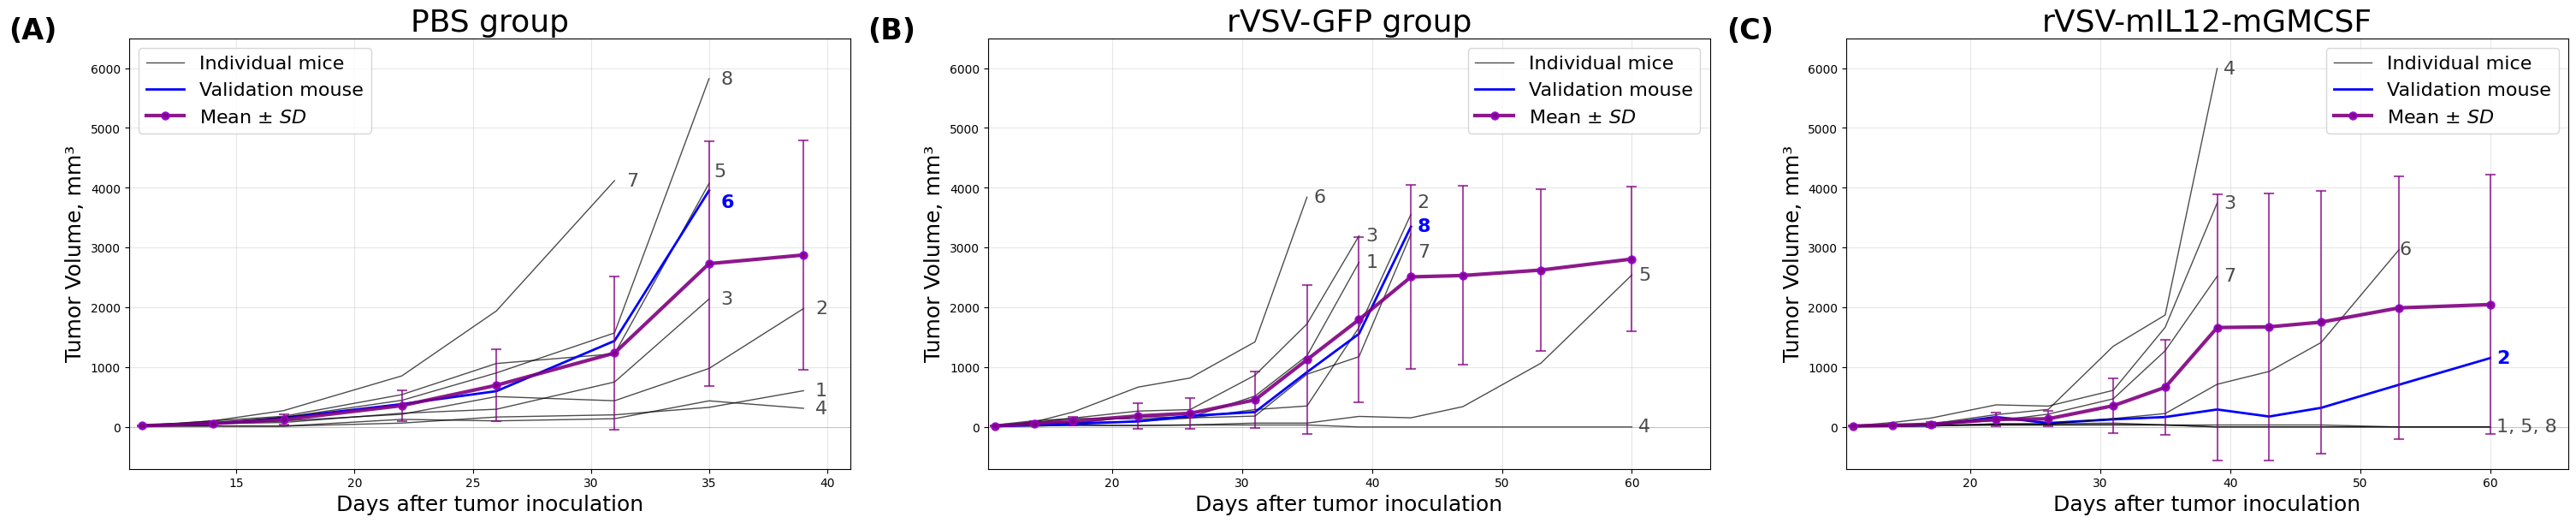

In [2]:
fig = plot_tumor_growth_comparison_grid(
    excel_path=['Tables/Separate_mice_PBS_group.xlsx',
                'Tables/Separate_mice_VSV_GFP_group.xlsx',
                'Tables/Separate_mice_VSV_mIL12_mGMCSF_group.xlsx'],
    exp_sheet_names=['All PBS', 'All VSV-GFP', 'All VSV-mIL12-mGMCSF'],
    xlabels=['Days after tumor inoculation'] * 3,
    ylabels=['Tumor Volume, mm³'] * 3,
    Titles=['PBS group', 'rVSV-GFP group', 'rVSV-mIL12-mGMCSF'], 
    highlight_mouse_ids=[6, 8, 2],
    show_mouse_id_flags=[False, False, False],
    langs=["en", "en", "en"],
    ymaxs=[6500, 6500, 6500],
    y_mins=[-700, -700, -700],
    figsize_per_plot=(10, 6),
    n_cols=3,
    subplot_signs=['(A)', '(B)', '(C)'],
    show_mean=False,
    show_mean_corrected=True,
    show_SD_on_mean_corrected=True,
    legend_fontsize=16,
    xlabel_fontsize=18,
    ylabel_fontsize=18,
    title_fontsize=26,
    line_indicators=[
        ['1', '2', '3', '4', '5', '6', '7', '8'],
        ['1', '2', '3', '4', '5', '6', '7', '8'],
        ['1, 5, 8', '2', '3', '4', None, '6', '7', None]
    ],
    line_indicator_offset_x=[
        [0.5, 0.5, 0.5, 0.5, 0.2, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5, None, 0.5, None]
    ],
    line_indicator_offset_y=[
        [0,0,0,0,200,-200,0,0],
        [0,200,0,0,0,0,-300,0],
        [0,0,0,0,None,0,0,None],
    ],
    line_indicator_fontsize=[
        [16,16,16,16,16,16,16,16],
        [16,16,16,16,16,16,16,16],
        [16,16,16,16,None,16,16,None]
    ],
    xmaxs=[41, 66, 66],
    force_show_zero_on_x=False,
    subplot_signs_fontsize=24,
    validation_mouse_lines = ['blue', 'blue', 'blue']
)

# A function to visualize a comparison of tumor growth curves used for model training and model predictions (Figure 6 D)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Union
import string

def plot_experiment_vs_simulation_comparison_single(
    excel_paths: Union[str, List[str]],
    sheet_names: Union[str, List[str]] = "Comparing",
    exp_column_name: str = "Experiment",
    sim_column_name: str = "Simulation",
    days_column_name: str = "Days",
    group_names: Optional[List[str]] = None,
    colors: Optional[List[str]] = None,
    exp_markers: Optional[List[str]] = None,
    Title: str = "Experiment vs Simulation Comparison",
    xlabel: str = "Days after tumor inoculation",
    ylabel: str = "Tumor volume, mm³",
    legend_fontsize: int = 12,
    xlabel_fontsize: int = 12,
    ylabel_fontsize: int = 12,
    title_fontsize: int = 14,
    ymax: Optional[float] = None,
    y_min: Optional[float] = None,
    xmax: Optional[float] = None,
    xmin: Optional[float] = None,
    figsize: tuple = (10, 6),
    exp_line_style: str = '-',
    exp_line_width: int = 2,
    exp_markersize: int = 8,
    sim_line_style: str = '--',
    sim_line_width: int = 2,
    show_legend: bool = True,
    legend_position: str = 'best',
    grid_alpha: float = 0.3,
    plot_sign: Optional[str] = None,
    plot_sign_fontsize: int = 16,
    plot_sign_fontweight: str = 'bold',
    plot_sign_xoffset: float = -0.1,
    plot_sign_yoffset: float = 1.05
):
    """
    Creates a single plot comparing experimental and simulated data for multiple groups.
    
    This function reads data from Excel files and creates a plot showing both experimental
    (with markers) and simulated (dashed lines) data for multiple treatment groups or
    experimental conditions. Each group gets a unique color, and experimental data points
    have distinct markers for easy differentiation.
    
    Parameters:
    -----------
    excel_paths : str or List[str]
        Path(s) to Excel file(s) containing the data. Can be a single string for one file
        or a list of strings for multiple files.
    sheet_names : str or List[str], optional
        Sheet name(s) within the Excel file(s) containing the data. Default is "Comparing".
        If a single string is provided, it will be used for all files.
    exp_column_name : str, optional
        Name of the column containing experimental data. Default is "Experiment".
    sim_column_name : str, optional
        Name of the column containing simulation data. Default is "Simulation".
    days_column_name : str, optional
        Name of the column containing day/time data. Default is "Days".
    group_names : List[str], optional
        Names for each group/condition. If not provided, defaults to "Group 1", "Group 2", etc.
    colors : List[str], optional
        Colors for each group's lines. If not provided, uses a default color palette.
    exp_markers : List[str], optional
        Marker styles for experimental data points for each group. If not provided,
        uses a sequence of different markers.
    Title : str, optional
        Title for the plot. Default is "Experiment vs Simulation Comparison".
    xlabel : str, optional
        Label for the x-axis. Default is "Days after tumor inoculation".
    ylabel : str, optional
        Label for the y-axis. Default is "Tumor volume, mm³".
    legend_fontsize : int, optional
        Font size for the legend text. Default is 12.
    xlabel_fontsize : int, optional
        Font size for the x-axis label. Default is 12.
    ylabel_fontsize : int, optional
        Font size for the y-axis label. Default is 12.
    title_fontsize : int, optional
        Font size for the plot title. Default is 14.
    ymax : float, optional
        Maximum value for the y-axis. If not provided, calculated from data.
    y_min : float, optional
        Minimum value for the y-axis. If not provided, calculated from data.
    xmax : float, optional
        Maximum value for the x-axis. If not provided, calculated from data.
    xmin : float, optional
        Minimum value for the x-axis. If not provided, calculated from data.
    figsize : tuple, optional
        Figure size as (width, height) in inches. Default is (10, 6).
    exp_line_style : str, optional
        Line style for experimental data lines. Default is solid line ('-').
    exp_line_width : int, optional
        Line width for experimental data lines. Default is 2.
    exp_markersize : int, optional
        Size of markers for experimental data points. Default is 8.
    sim_line_style : str, optional
        Line style for simulated data lines. Default is dashed line ('--').
    sim_line_width : int, optional
        Line width for simulated data lines. Default is 2.
    show_legend : bool, optional
        Whether to show the legend. Default is True.
    legend_position : str, optional
        Position of the legend. Default is 'best' (matplotlib automatically chooses).
    grid_alpha : float, optional
        Transparency of the grid lines (0 = transparent, 1 = opaque). Default is 0.3.
    plot_sign : str, optional
        Letter or symbol to label the plot (e.g., 'A', 'B'). If None, no label is added.
    plot_sign_fontsize : int, optional
        Font size for the plot sign label. Default is 16.
    plot_sign_fontweight : str, optional
        Font weight for the plot sign label. Default is 'bold'.
    plot_sign_xoffset : float, optional
        X-offset for the plot sign label in axes coordinates (0-1). Default is -0.1.
    plot_sign_yoffset : float, optional
        Y-offset for the plot sign label in axes coordinates (0-1). Default is 1.05.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure object.
    matplotlib.axes.Axes
        The axes object containing the plot.
    """
    
    # ==================== PARAMETER PREPARATION ====================
    
    # Convert single file path to list for uniform processing
    if isinstance(excel_paths, str):
        excel_paths = [excel_paths]
    
    # Convert single sheet name to list for uniform processing
    if isinstance(sheet_names, str):
        sheet_names = [sheet_names] * len(excel_paths)
    
    # Determine number of groups to plot (minimum of available files and sheet names)
    n_groups = min(len(excel_paths), len(sheet_names))
    
    # Create default group names if not provided
    if group_names is None:
        group_names = [f"Group {i+1}" for i in range(n_groups)]
    # If provided but insufficient, create additional names
    elif len(group_names) < n_groups:
        group_names = group_names + [f"Group {i+1}" for i in range(len(group_names), n_groups)]
    
    # Set colors for each group
    if colors is None:
        # Default Matplotlib color palette for good contrast
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        colors = colors[:n_groups]  # Take only as many as needed
    # If provided but insufficient, pad with gray
    elif len(colors) < n_groups:
        colors = colors + ['gray'] * (n_groups - len(colors))
    
    # Set markers for experimental data points
    if exp_markers is None:
        # Default sequence of marker styles
        exp_markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'd']
        exp_markers = exp_markers[:n_groups]  # Take only as many as needed
    # If provided but insufficient, pad with circle markers
    elif len(exp_markers) < n_groups:
        exp_markers = exp_markers + ['o'] * (n_groups - len(exp_markers))
    
    # ==================== CREATE FIGURE ====================
    
    # Create figure and axes with specified size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Lists to collect all data points for automatic axis limit calculation
    all_x_values = []
    all_y_values = []
    
    # ==================== PLOT DATA FOR EACH GROUP ====================
    
    for group_idx in range(n_groups):
        try:
            # Read data from Excel file
            df = pd.read_excel(excel_paths[group_idx], sheet_name=sheet_names[group_idx])
            
            # ==================== COLUMN IDENTIFICATION ====================
            
            # Initialize variables to store column names
            days_col = None
            exp_col = None
            sim_col = None
            
            # Search for columns by name (case-insensitive)
            for col in df.columns:
                if col.lower() == days_column_name.lower():
                    days_col = col
                elif col.lower() == exp_column_name.lower():
                    exp_col = col
                elif col.lower() == sim_column_name.lower():
                    sim_col = col
            
            # Fallback: if columns not found by name, use positional defaults
            if days_col is None and len(df.columns) > 0:
                days_col = df.columns[0]  # First column assumed to be days
            if exp_col is None and len(df.columns) > 1:
                exp_col = df.columns[1]  # Second column assumed to be experimental data
            if sim_col is None and len(df.columns) > 2:
                sim_col = df.columns[2]  # Third column assumed to be simulation data
            
            # Skip this group if no days column found
            if days_col is None:
                continue
            
            # ==================== DATA EXTRACTION ====================
            
            # Extract days data and convert to numeric, handling errors
            days = pd.to_numeric(df[days_col], errors='coerce').values
            
            # ==================== PLOT EXPERIMENTAL DATA ====================
            
            if exp_col is not None and exp_col in df.columns:
                # Extract experimental data and convert to numeric
                exp_data = pd.to_numeric(df[exp_col], errors='coerce').values
                
                # Find indices where both days and experimental data are valid (not NaN)
                exp_valid_idx = ~np.isnan(exp_data) & ~np.isnan(days[:len(exp_data)])
                exp_days_valid = days[:len(exp_data)][exp_valid_idx]
                exp_data_valid = exp_data[exp_valid_idx]
                
                # Plot experimental data if valid points exist
                if len(exp_days_valid) > 0:
                    ax.plot(exp_days_valid, exp_data_valid, 
                           color=colors[group_idx], 
                           linewidth=exp_line_width, 
                           linestyle=exp_line_style,
                           marker=exp_markers[group_idx],
                           markersize=exp_markersize,
                           markerfacecolor=colors[group_idx],
                           markeredgecolor='black',  # Black edge for better visibility
                           markeredgewidth=1,
                           alpha=0.9,
                           zorder=10,  # High zorder to ensure experimental data is on top
                           label=f"{group_names[group_idx]} (Experiment)")
                    
                    # Add to lists for axis limit calculation
                    all_x_values.extend(exp_days_valid)
                    all_y_values.extend(exp_data_valid)
            
            # ==================== PLOT SIMULATION DATA ====================
            
            if sim_col is not None and sim_col in df.columns:
                # Extract simulation data and convert to numeric
                sim_data = pd.to_numeric(df[sim_col], errors='coerce').values
                
                # Find indices where both days and simulation data are valid (not NaN)
                sim_valid_idx = ~np.isnan(sim_data) & ~np.isnan(days[:len(sim_data)])
                sim_days_valid = days[:len(sim_data)][sim_valid_idx]
                sim_data_valid = sim_data[sim_valid_idx]
                
                # Plot simulation data if valid points exist
                if len(sim_days_valid) > 0:
                    ax.plot(sim_days_valid, sim_data_valid, 
                           color=colors[group_idx], 
                           linewidth=sim_line_width, 
                           linestyle=sim_line_style,
                           alpha=0.7,
                           zorder=5,  # Lower zorder than experimental data
                           label=f"{group_names[group_idx]} (Simulation)")
                    
                    # Add to lists for axis limit calculation
                    all_x_values.extend(sim_days_valid)
                    all_y_values.extend(sim_data_valid)
                    
        except Exception as e:
            # Handle errors gracefully and continue with other groups
            print(f"Error processing group {group_idx+1} ({group_names[group_idx]}): {str(e)}")
    
    # ==================== PLOT CONFIGURATION ====================
    
    # Set axis labels and title with specified font sizes
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    ax.set_title(Title, fontsize=title_fontsize)
    
    # Add grid with specified transparency
    ax.grid(True, alpha=grid_alpha)
    
    # ==================== AXIS LIMITS CALCULATION ====================
    
    # Calculate automatic axis limits based on data
    if all_x_values:
        auto_xmax = max(all_x_values)
        auto_xmax_with_margin = auto_xmax * 1.05  # Add 5% margin
        auto_xmin = min(all_x_values)
        # Add margin, but handle negative values differently
        auto_xmin_with_margin = auto_xmin * 0.95 if auto_xmin > 0 else auto_xmin * 1.05
    else:
        # Default values if no data points
        auto_xmax_with_margin = 100
        auto_xmin_with_margin = 0
    
    # Set maximum x-axis limit (user-specified or automatic)
    if xmax is not None:
        ax.set_xlim(right=xmax)
    else:
        ax.set_xlim(right=auto_xmax_with_margin)
    
    # Set minimum x-axis limit (user-specified or automatic)
    if xmin is not None:
        ax.set_xlim(left=xmin)
    else:
        ax.set_xlim(left=auto_xmin_with_margin)
    
    # Calculate automatic y-axis limits based on data
    if all_y_values:
        auto_ymax = max(all_y_values)
        auto_ymax_with_margin = auto_ymax * 1.1  # Add 10% margin
        auto_ymin = min(all_y_values)
        # Add margin, but handle negative values differently
        auto_ymin_with_margin = auto_ymin * 0.9 if auto_ymin > 0 else auto_ymin * 1.1
    else:
        # Default values if no data points
        auto_ymax_with_margin = 100
        auto_ymin_with_margin = 0
    
    # Set maximum y-axis limit (user-specified or automatic)
    if ymax is not None:
        ax.set_ylim(top=ymax)
    else:
        ax.set_ylim(top=auto_ymax_with_margin)
    
    # Set minimum y-axis limit (user-specified or automatic)
    if y_min is not None:
        user_ymin = y_min
        ax.set_ylim(bottom=user_ymin)
        
        # Add a reference line at y=0 if y_min is negative
        if user_ymin < 0:
            ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    else:
        ax.set_ylim(bottom=auto_ymin_with_margin)
    
    # ==================== LEGEND ====================
    
    # Add legend if requested
    if show_legend:
        ax.legend(loc=legend_position, fontsize=legend_fontsize)
    
    # ==================== PLOT SIGNATURE ====================
    
    # Add plot sign (e.g., 'A', 'B') for multi-plot figures
    if plot_sign is not None:
        # Plot sign is positioned in axes coordinates (0-1 range, not data coordinates)
        ax.text(plot_sign_xoffset, plot_sign_yoffset, plot_sign, 
               transform=ax.transAxes,  # Use axes coordinates
               fontsize=plot_sign_fontsize,
               fontweight=plot_sign_fontweight,
               verticalalignment='top',
               horizontalalignment='right')
    
    # Return figure and axes objects for further customization if needed
    return fig, ax

## Figure 6 D

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Tumor growth curves: Experiment vs Simulation'}, xlabel='Days after tumor inoculation', ylabel='Tumor volume, mm³'>)

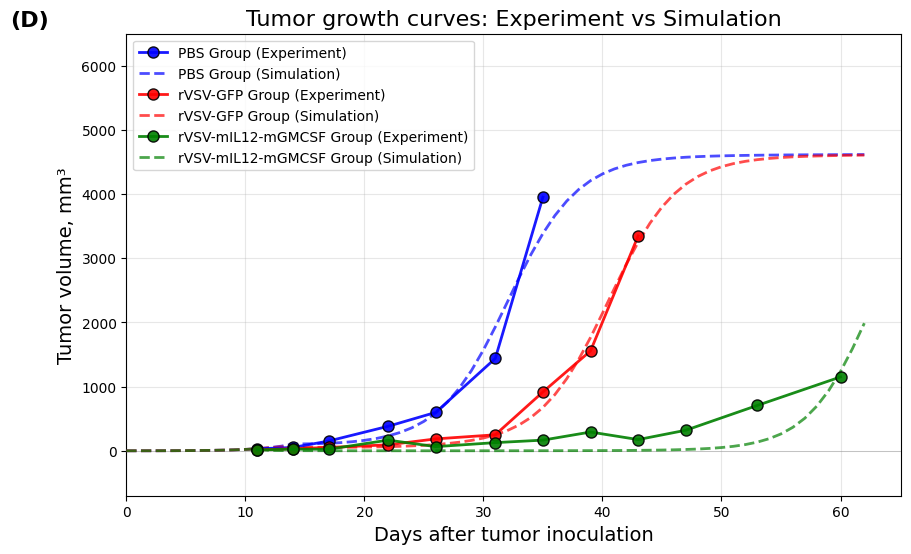

In [5]:
plot_experiment_vs_simulation_comparison_single(
    excel_paths=["Tables/Separate_mice_PBS_group.xlsx",
                 "Tables/Separate_mice_VSV_GFP_group.xlsx",
                 "Tables/Separate_mice_VSV_mIL12_mGMCSF_group.xlsx"],
    sheet_names=["Comparing PBS",
                 "Comparing VSV",
                 "Comparing VSV-mIL12-mGMCSF"],
    group_names=["PBS Group",
                 "rVSV-GFP Group",
                 "rVSV-mIL12-mGMCSF Group"],
    colors=['blue', 'red', 'green'],
    exp_markers=['o',
                 'o',
                 'o'],
    Title="Tumor growth curves: Experiment vs Simulation",
    xlabel="Days after tumor inoculation",
    ylabel="Tumor volume, mm³",
    figsize=(10, 6),
    legend_position='upper left',
    legend_fontsize=10,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    title_fontsize=16,
    ymax=6500,
    y_min= -700,
    plot_sign = '(D)',
)

# A function to visualize the objective function values for optimizations for the three study groups (Figure 6 E)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Optional, Union, Tuple, Any

def barplot_simple(file_paths, sheet_names, exp_col, sim_col, time_col='Days', 
                     figsize=(14, 7), labels=None, x_label='Datasets', 
                     x_label_fontsize=12, y_label='RMSE', y_label_fontsize=12,
                     show_values=True, values_fontsize=12, title=None, title_fontsize=14, 
                     labels_fontsize=11, sign=None, bars_delimiter=0.8,
                     sign_fontsize=16, sign_fontweight='bold',
                     sign_xoffset=-0.1, sign_yoffset=1.05,
                     bars_colors: Optional[Union[str, List[str], List[Tuple[float, float, float]]]] = None,
                     method: str = "RMSE",
                     manual_values: Optional[List[float]] = None):
    """
    Simplified version of a function for plotting various error metrics as bar charts.
    
    This function reads experimental and simulated data from Excel files, calculates error metrics
    (RMSE, distance, or objective function), and displays them as a bar chart. It can also display
    manually provided values without calculation.
    
    Parameters:
    -----------
    file_paths : List[str]
        List of paths to Excel files containing data.
    sheet_names : List[str]
        List of sheet names for each Excel file.
    exp_col : str
        Name of the column containing experimental data.
    sim_col : str
        Name of the column containing simulated data.
    time_col : str, optional
        Name of the column containing time points. Default is 'Days'.
    figsize : Tuple[float, float], optional
        Size of the figure (width, height) in inches. Default is (14, 7).
    labels : List[str], optional
        Custom labels for each dataset (bar). If None, automatic labels are generated.
    x_label : str, optional
        Label for the x-axis. Default is 'Datasets'.
    x_label_fontsize : int, optional
        Font size for the x-axis label. Default is 12.
    y_label : str, optional
        Label for the y-axis. Default is 'RMSE' (will adapt to method if default is used).
    y_label_fontsize : int, optional
        Font size for the y-axis label. Default is 12.
    show_values : bool, optional
        Whether to display metric values above each bar. Default is True.
    values_fontsize : int, optional
        Font size for values displayed above bars. Default is 12.
    title : str, optional
        Title for the plot. If None, no title is displayed.
    title_fontsize : int, optional
        Font size for the plot title. Default is 14.
    labels_fontsize : int, optional
        Font size for x-axis labels. Default is 11.
    sign : str, optional
        Letter or symbol to label the plot (e.g., 'A', 'B'). Displayed in top-left corner.
    bars_delimiter : float, optional
        Width of each bar (spacing between bars). Default is 0.8.
    sign_fontsize : int, optional
        Font size for the plot sign. Default is 16.
    sign_fontweight : str, optional
        Font weight for the plot sign. Default is 'bold'.
    sign_xoffset : float, optional
        X-offset for the plot sign in axes coordinates. Default is -0.1 (left of axis).
    sign_yoffset : float, optional
        Y-offset for the plot sign in axes coordinates. Default is 1.05 (above axis).
    bars_colors : str, List[str], or List[Tuple[float, float, float]], optional
        Colors for the bars. Can be:
        - str: Single color for all bars (e.g., 'blue', '#FF5733')
        - List[str]: List of colors for each bar
        - List[Tuple]: List of RGB/RGBA tuples
        If None, uses a default color palette.
    method : str, optional
        Error metric calculation method:
        - "RMSE": Root Mean Square Error (default)
        - "DISTANCE": Distance between simulated and experimental points 
          (square root of sum of squared differences)
        - "OBJECTIVE_FUNCTION": Objective function (sum of squared differences)
          according to formula: f = Σ (Q_i - Q_i_exp)²
    manual_values : List[float], optional
        Array of values to display directly without calculation. If provided, metric
        calculation is skipped and these values are used for plotting.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing calculation results for each file, including:
        - File name
        - Sheet name
        - Calculated metric value
        - Number of data points
    """
    
    # ==================== INPUT VALIDATION ====================
    
    # Check that number of files matches number of sheet names
    if len(file_paths) != len(sheet_names):
        raise ValueError("Number of files must match number of sheet names")
    
    # Validate the method parameter
    method = method.upper()
    valid_methods = ["RMSE", "DISTANCE", "OBJECTIVE_FUNCTION", "OBJ_FUNC"]
    if method not in valid_methods:
        raise ValueError(f"Invalid method parameter: {method}. Valid values: {valid_methods}")
    
    # Allow shorthand for objective function
    if method == "OBJ_FUNC":
        method = "OBJECTIVE_FUNCTION"
    
    # Initialize storage for results
    results = []
    metric_values = []
    generated_labels = []
    
    # ==================== PROCESSING LOGIC ====================
    
    # If manual values are provided, use them directly
    if manual_values is not None:
        print(f"Using manual values: {manual_values}")
        metric_values = manual_values.copy()
        
        # Generate labels for manual values
        for idx, (file_path, sheet_name) in enumerate(zip(file_paths, sheet_names)):
            file_name = Path(file_path).stem
            
            # Use provided labels or generate automatic ones
            if labels and idx < len(labels):
                generated_labels.append(labels[idx])
            else:
                # Create a readable label from file and sheet names
                short_name = sheet_name if len(sheet_name) < 20 else sheet_name[:17] + "..."
                generated_labels.append(f"{file_name}\n{short_name}")
            
            # Create results entries for manual values
            results.append({
                'File': file_name,
                'Sheet': sheet_name,
                'Manual_Value': manual_values[idx] if idx < len(manual_values) else None,
                'Data_Points': 0  # Not applicable for manual values
            })
        
        # Validate that number of manual values matches number of files
        if len(metric_values) != len(file_paths):
            print(f"Warning: Number of manual values ({len(metric_values)}) doesn't match number of files ({len(file_paths)})")
    
    else:
        # ==================== METRIC CALCULATION ====================
        # Process each file and calculate the selected error metric
        
        for idx, (file_path, sheet_name) in enumerate(zip(file_paths, sheet_names)):
            try:
                # Read data from Excel file
                df = pd.read_excel(file_path, sheet_name=sheet_name)
            except Exception as e:
                print(f"Error reading {file_path} ({sheet_name}): {e}")
                continue
            
            # Check if required columns exist
            if exp_col not in df.columns or sim_col not in df.columns:
                print(f"Warning: {file_path} ({sheet_name}) missing required columns")
                continue
            
            # Clean data by removing rows with NaN in experimental or simulated columns
            df_clean = df.dropna(subset=[exp_col, sim_col])
            
            if len(df_clean) > 0:
                # Calculate metric based on selected method
                if method == "RMSE":
                    # Calculate Root Mean Square Error
                    # RMSE = sqrt(mean((experimental - simulated)²))
                    mse = np.mean((df_clean[exp_col] - df_clean[sim_col]) ** 2)
                    metric = np.sqrt(mse)
                    metric_name = "RMSE"
                    
                elif method == "DISTANCE":
                    # Calculate Euclidean distance between experimental and simulated points
                    # Distance = sqrt(Σ(experimental - simulated)²)
                    squared_diff_sum = np.sum((df_clean[exp_col] - df_clean[sim_col]) ** 2)
                    metric = np.sqrt(squared_diff_sum)
                    metric_name = "Distance"
                    
                elif method == "OBJECTIVE_FUNCTION":
                    # Calculate objective function (unweighted sum of squared differences)
                    # f = Σ (Q_i - Q_i_exp)²
                    # This is the same as the sum of squared errors (SSE)
                    
                    # Get experimental and simulated values
                    exp_values = df_clean[exp_col].values
                    sim_values = df_clean[sim_col].values
                    
                    # Calculate sum of squared differences
                    # This is simply the squared differences between simulated and experimental values
                    squared_diff_sum = np.sum((sim_values - exp_values) ** 2)
                    
                    metric = squared_diff_sum
                    metric_name = "Objective_Function"
                
                # Store calculated metric
                metric_values.append(metric)
                
                # Generate file name without extension
                file_name = Path(file_path).stem
                
                # Create labels for this dataset
                if labels and idx < len(labels):
                    generated_labels.append(labels[idx])
                else:
                    # Truncate long sheet names for readability
                    short_name = sheet_name if len(sheet_name) < 20 else sheet_name[:17] + "..."
                    generated_labels.append(f"{file_name}\n{short_name}")
                
                # Store results with appropriate information
                results.append({
                    'File': file_name,
                    'Sheet': sheet_name,
                    metric_name: metric,
                    'Data_Points': len(df_clean)
                })
    
    # Check if any data was successfully processed
    if not metric_values:
        print("No data available for plotting")
        return pd.DataFrame()
    
    # ==================== LABEL PROCESSING ====================
    
    # Determine final labels for x-axis
    if labels and len(labels) != len(metric_values):
        print(f"Warning: Provided labels count ({len(labels)}) doesn't match bars count ({len(metric_values)})")
        # Fall back to generated labels
        final_labels = generated_labels
    elif labels:
        # Use provided labels
        final_labels = labels
    else:
        # Use automatically generated labels
        final_labels = generated_labels
    
    # ==================== COLOR PROCESSING ====================
    
    # Determine colors for bars based on user input or defaults
    if bars_colors is None:
        # Use default color palette
        if len(metric_values) <= 10:
            colors = plt.cm.Set3(np.linspace(0, 1, len(metric_values)))
        else:
            colors = plt.cm.tab20(np.linspace(0, 1, len(metric_values)))
    elif isinstance(bars_colors, str):
        # Single color for all bars
        colors = [bars_colors] * len(metric_values)
    elif isinstance(bars_colors, list) and len(bars_colors) == len(metric_values):
        # List of colors matching number of bars
        colors = bars_colors
    elif isinstance(bars_colors, list) and len(bars_colors) < len(metric_values):
        # Fewer colors than bars - repeat colors
        colors = []
        for i in range(len(metric_values)):
            colors.append(bars_colors[i % len(bars_colors)])
        print(f"Warning: Fewer colors ({len(bars_colors)}) than bars ({len(metric_values)}). Colors will repeat.")
    elif isinstance(bars_colors, list) and len(bars_colors) > len(metric_values):
        # More colors than bars - use only needed colors
        colors = bars_colors[:len(metric_values)]
        print(f"Warning: More colors ({len(bars_colors)}) than bars ({len(metric_values)}). Using first {len(metric_values)} colors.")
    else:
        # Invalid format - use defaults
        print("Warning: Invalid bars_colors format. Using default color palette.")
        if len(metric_values) <= 10:
            colors = plt.cm.Set3(np.linspace(0, 1, len(metric_values)))
        else:
            colors = plt.cm.tab20(np.linspace(0, 1, len(metric_values)))
    
    # ==================== Y-AXIS LABEL ADAPTATION ====================
    
    # Adapt y-axis label based on method or user input
    if manual_values is not None:
        # For manual values, use custom label or default to 'Values'
        y_axis_label = y_label if y_label != 'RMSE' else 'Values'
    elif y_label == 'RMSE':
        # If user used default label, adapt it to the method
        if method == "RMSE":
            y_axis_label = 'RMSE'
        elif method == "DISTANCE":
            y_axis_label = 'Distance'
        else:  # OBJECTIVE_FUNCTION
            y_axis_label = 'Objective Function (SSE)'
    else:
        # User provided custom label - use it as is
        y_axis_label = y_label
    
    # ==================== PLOTTING ====================
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar positions (equally spaced)
    x_positions = np.arange(len(metric_values))
    
    # Create bars with specified colors and width
    bars = ax.bar(x_positions, metric_values, 
                  color=colors, 
                  edgecolor='black', 
                  width=bars_delimiter)
    
    # Add values above bars if requested
    if show_values:
        for bar, value in zip(bars, metric_values):
            # Format number based on magnitude
            if abs(value) < 0.01 or abs(value) > 1000:
                text = f'{value:.2e}'  # Scientific notation for extreme values
            else:
                text = f'{value:.2f}'  # Two decimal places for normal values
            
            # Position text above bar
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() * 1.01,  # 1% above bar
                    text, 
                    ha='center', 
                    va='bottom', 
                    fontsize=values_fontsize)
    
    # ==================== PLOT CONFIGURATION ====================
    
    # Set axis labels with specified font sizes
    ax.set_xlabel(x_label, fontsize=x_label_fontsize)
    ax.set_ylabel(y_axis_label, fontsize=y_label_fontsize)
    
    # Add title if provided
    if title:
        ax.set_title(title, fontsize=title_fontsize, pad=20)
    
    # Configure x-axis tick labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(final_labels, 
                       rotation=45,  # Rotate for readability
                       ha='right',  # Align to right for better spacing
                       fontsize=labels_fontsize)
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add plot sign (e.g., 'A', 'B') for multi-plot figures
    if sign is not None:
        ax.text(sign_xoffset, sign_yoffset, sign, 
               transform=ax.transAxes,  # Use axes coordinates (0-1)
               fontsize=sign_fontsize,
               fontweight=sign_fontweight,
               va='top',  # Vertical alignment
               ha='right')  # Horizontal alignment
    
    # ==================== AXIS LIMITS ====================
    
    # Auto-adjust y-axis limits for better visualization
    max_value = max(metric_values)
    if max_value > 0:
        # Add 15% margin above highest value
        ax.set_ylim(0, max_value * 1.15)
    else:
        # Handle case with all negative or zero values
        min_value = min(metric_values)
        ax.set_ylim(min_value * 1.15, 0)
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    # ==================== RESULTS PROCESSING ====================
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # ==================== SUMMARY STATISTICS ====================
    
    # Print comprehensive summary
    print("\n" + "="*60)
    if manual_values is not None:
        print("RESULTS SUMMARY (Manual Values):")
    else:
        print(f"RESULTS SUMMARY (Method: {method}):")
    print("="*60)
    
    if manual_values is not None:
        # Statistics for manual values
        print(f"Number of values: {len(results_df)}")
        print(f"Mean value: {np.mean(manual_values):.4f}")
        print(f"Standard deviation: {np.std(manual_values):.4f}")
        print(f"Minimum value: {min(manual_values):.4f}")
        print(f"Maximum value: {max(manual_values):.4f}")
        print(f"Sum of values: {sum(manual_values):.4f}")
    else:
        # Statistics for calculated metrics
        metric_column = metric_name
        print(f"Total number of datasets: {len(results_df)}")
        print(f"Total data points across all datasets: {results_df['Data_Points'].sum()}")
        print(f"Mean {metric_column}: {results_df[metric_column].mean():.4f}")
        print(f"Standard deviation of {metric_column}: {results_df[metric_column].std():.4f}")
        print(f"Minimum {metric_column}: {results_df[metric_column].min():.4f}")
        print(f"Maximum {metric_column}: {results_df[metric_column].max():.4f}")
        
        # Note: Removed the w_min output since objective function is now unweighted
    
    # Print detailed results table
    print("\nDetailed results:")
    if manual_values is not None:
        print(results_df[['File', 'Sheet', 'Manual_Value']].to_string(index=False))
    else:
        print(results_df[['File', 'Sheet', metric_column, 'Data_Points']].to_string(index=False))
    
    return results_df

## Figure 6 E

Using manual values: [13881.798725101537, 4482.967105544334, 75280.48663569803]


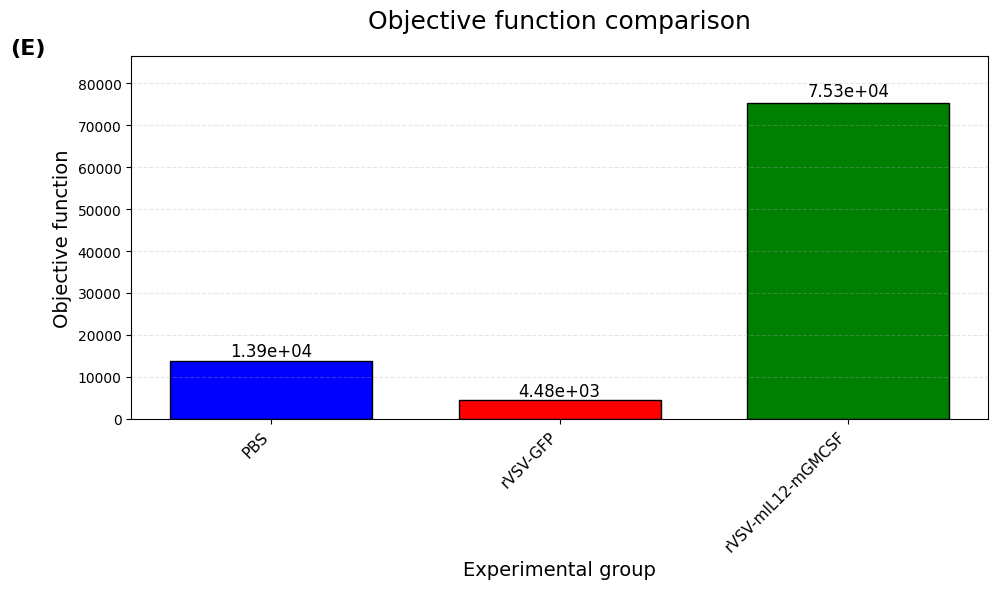


RESULTS SUMMARY (Manual Values):
Number of values: 3
Mean value: 31215.0842
Standard deviation: 31394.3124
Minimum value: 4482.9671
Maximum value: 75280.4866
Sum of values: 93645.2525

Detailed results:
                                File                      Sheet  Manual_Value
             Separate_mice_PBS_group              Comparing PBS  13881.798725
         Separate_mice_VSV_GFP_group              Comparing VSV   4482.967106
Separate_mice_VSV_mIL12_mGMCSF_group Comparing VSV-mIL12-mGMCSF  75280.486636


,File,Sheet,Manual_Value,Data_Points
0,Separate_mice_PBS_group,Comparing PBS,13881.798725,0
1,Separate_mice_VSV_GFP_group,Comparing VSV,4482.967106,0
2,Separate_mice_VSV_mIL12_mGMCSF_group,Comparing VSV-mIL12-mGMCSF,75280.486636,0


In [ ]:
barplot_simple(
        file_paths=['Tables/Separate_mice_PBS_group.xlsx',
                    'Tables/Separate_mice_VSV_GFP_group.xlsx',
                    'Tables/Separate_mice_VSV_mIL12_mGMCSF_group.xlsx'],
        sheet_names=['Comparing PBS',
                     'Comparing VSV',
                     'Comparing VSV-mIL12-mGMCSF'],
        exp_col='Experiment',
        sim_col='Simulation',
        time_col='Days',
        x_label='Experimental group',
        y_label='Objective function',
        labels = ['PBS', 'rVSV-GFP', 'rVSV-mIL12-mGMCSF'],
        x_label_fontsize=14,
        y_label_fontsize=14,
        figsize=(10, 6),
        show_values=True,
        title='Objective function comparison',
        labels_fontsize=11,
        sign='(E)',
        bars_delimiter=0.7,
        title_fontsize = 18,
        bars_colors=['blue', 'red', 'green'],
        manual_values = [13881.798725101537, 4482.967105544334, 75280.48663569803]
    )

# A function to visualize the identifiability plots for fitted model parameters (Figure 6 F, G, and H)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Union, Any
import string

def plot_identifiability_fixed(
    excel_files: Union[str, List[str]],
    sheet_names: List[str],
    start_param_col: str,
    start_obj_col: str,
    bound_line_col: str,
    param_values_col: str,
    obj_values_col: str,
    xmin_col: str,
    xmax_col: str,
    ymin_col: str,
    ymax_col: str,
    ylabels: List[str],
    ylabel_fontsize: Union[int, List[int]],
    xlabels: List[str],
    xlabel_fontsize: Union[int, List[int]],
    subplot_signs: Optional[List[str]] = None,
    n_cols: int = 2,
    subplot_signs_fontsize: int = 16,
    lines_colors: Optional[Union[str, List[str]]] = None
):
    """
    Fixed version of the plot_identifiability function.
    
    This function creates a grid of identifiability plots showing objective function
    values versus parameter values. Each plot displays how the objective function 
    changes as a parameter is varied, with a reference line indicating an acceptability
    threshold. This is useful for parameter identifiability analysis in optimization.
    
    Parameters:
    -----------
    excel_files : str or List[str]
        Path(s) to Excel file(s) containing the data. If a single string is provided,
        the same file is used for all plots.
    sheet_names : List[str]
        List of sheet names within the Excel file(s) for each plot.
    start_param_col : str
        Column name for the starting parameter value (optimal parameter).
    start_obj_col : str
        Column name for the starting objective function value (optimal objective).
    bound_line_col : str
        Column name for the bound line value (horizontal reference line threshold).
    param_values_col : str
        Column name for parameter values (x-axis values for the curve).
    obj_values_col : str
        Column name for objective function values (y-axis values for the curve).
    xmin_col : str
        Column name for x-axis minimum limit.
    xmax_col : str
        Column name for x-axis maximum limit.
    ymin_col : str
        Column name for y-axis minimum limit.
    ymax_col : str
        Column name for y-axis maximum limit.
    ylabels : List[str]
        Y-axis labels for each subplot.
    ylabel_fontsize : int or List[int]
        Font size(s) for y-axis labels. If int, same size for all plots.
    xlabels : List[str]
        X-axis labels for each subplot.
    xlabel_fontsize : int or List[int]
        Font size(s) for x-axis labels. If int, same size for all plots.
    subplot_signs : List[str], optional
        Letters or symbols to label each subplot (e.g., ['A', 'B', 'C']).
        If None, automatically generates letters from the alphabet.
    n_cols : int, optional
        Number of columns in the subplot grid. Default is 2.
    subplot_signs_fontsize : int, optional
        Font size for subplot sign labels. Default is 16.
    lines_colors : str or List[str], optional
        Color(s) for lines and points on each subplot.
        If str - single color for all plots.
        If List[str] - list of colors for each plot separately.
        Default is 'b' (blue).
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure with multiple identifiability plots.
    """
    
    # Determine number of plots from sheet names list
    n_plots = len(sheet_names)
    
    # Handle single file input by repeating it for all plots
    if isinstance(excel_files, str):
        excel_files = [excel_files] * n_plots
    elif len(excel_files) != n_plots:
        # If number of files doesn't match plots, use first file for all plots
        excel_files = [excel_files[0]] * n_plots
    
    # ==================== LINE COLORS PREPARATION ====================
    
    # Prepare the lines_colors parameter
    if lines_colors is None:
        line_colors_list = ['b'] * n_plots  # Default blue for all plots
    elif isinstance(lines_colors, str):
        line_colors_list = [lines_colors] * n_plots  # Single color for all plots
    elif isinstance(lines_colors, list):
        if len(lines_colors) < n_plots:
            # If fewer colors than plots, repeat the last color or use blue
            if len(lines_colors) > 0:
                last_color = lines_colors[-1]
                line_colors_list = lines_colors + [last_color] * (n_plots - len(lines_colors))
            else:
                line_colors_list = ['b'] * n_plots
        else:
            # Use provided colors, trim if more than needed
            line_colors_list = lines_colors[:n_plots]
    else:
        # Fallback to default blue
        line_colors_list = ['b'] * n_plots
    
    # ==================== SUBPLOT SIGNS PREPARATION ====================
    
    # Prepare subplot signs (letters A, B, C, etc.) 
    if subplot_signs is None:
        # Default: use first N letters of alphabet
        subplot_signs = list(string.ascii_uppercase[:n_plots])
    elif len(subplot_signs) < n_plots:
        # If fewer signs than plots, extend the sequence
        existing_signs = subplot_signs.copy()
        if existing_signs:
            last_char = existing_signs[-1]
            if last_char in string.ascii_uppercase:
                # Find position of last character and continue from next one
                start_idx = string.ascii_uppercase.index(last_char) + 1
            else:
                start_idx = 0
        else:
            start_idx = 0
        
        # Generate additional signs
        additional_signs = list(string.ascii_uppercase[start_idx:start_idx + (n_plots - len(existing_signs))])
        subplot_signs = existing_signs + additional_signs
    elif len(subplot_signs) > n_plots:
        # Trim if more signs than plots
        subplot_signs = subplot_signs[:n_plots]
    
    # ==================== FONT SIZE PREPARATION ====================
    
    # Prepare ylabel font sizes
    if isinstance(ylabel_fontsize, int):
        ylabel_fontsizes = [ylabel_fontsize] * n_plots  # Same size for all plots
    elif isinstance(ylabel_fontsize, list):
        # Use provided sizes, pad with default (12) if not enough
        ylabel_fontsizes = ylabel_fontsize[:n_plots] + [12] * (n_plots - len(ylabel_fontsize))
    else:
        ylabel_fontsizes = [12] * n_plots  # Default size
    
    # Prepare xlabel font sizes
    if isinstance(xlabel_fontsize, int):
        xlabel_fontsizes = [xlabel_fontsize] * n_plots  # Same size for all plots
    elif isinstance(xlabel_fontsize, list):
        # Use provided sizes, pad with default (12) if not enough
        xlabel_fontsizes = xlabel_fontsize[:n_plots] + [12] * (n_plots - len(xlabel_fontsize))
    else:
        xlabel_fontsizes = [12] * n_plots  # Default size
    
    # ==================== FIGURE AND SUBPLOT CREATION ====================
    
    # Calculate number of rows needed for the grid
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
    
    # Set consistent figure size per plot
    figsize_per_plot = (6, 4)
    total_width = figsize_per_plot[0] * n_cols
    total_height = figsize_per_plot[1] * n_rows
    
    # Create the subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(total_width, total_height),
                            squeeze=False,  # Always return 2D array of axes
                            constrained_layout=True)  # Better spacing
    
    # Flatten the axes array for easier indexing
    axes_flat = axes.flatten()
    
    # ==================== PLOT EACH SUBPLOT ====================
    
    for idx, sheet_name in enumerate(sheet_names):
        ax = axes_flat[idx]
        
        try:
            # Read data from Excel file
            df = pd.read_excel(excel_files[idx], sheet_name=sheet_name)
            
            # ==================== EXTRACT SINGLE VALUES ====================
            
            # Extract single-value parameters (from first row)
            start_param = df.at[0, start_param_col]      # Optimal parameter value
            start_obj = df.at[0, start_obj_col]          # Optimal objective value
            bound_value = df.at[0, bound_line_col]       # Threshold line value
            
            # ==================== EXTRACT CURVE DATA ====================
            
            # Drop NaN values from parameter column to get valid data points
            param_series = df[param_values_col].dropna()
            # Get corresponding objective values for the same rows
            obj_series = df.loc[param_series.index, obj_values_col]
            
            # Convert to numpy arrays for plotting
            param_values = param_series.values.astype(float)
            obj_values = obj_series.values.astype(float)
            
            # ==================== EXTRACT AXIS LIMITS ====================
            
            # Extract axis limits from first row
            xmin = df.at[0, xmin_col]
            xmax = df.at[0, xmax_col]
            ymin = df.at[0, ymin_col]
            ymax = df.at[0, ymax_col]
            
            # ==================== SORT DATA FOR SMOOTH PLOTTING ====================
            
            # Sort by parameter values for a smooth curve
            sorted_indices = np.argsort(param_values)
            param_sorted = param_values[sorted_indices]
            obj_sorted = obj_values[sorted_indices]
            
            # ==================== COLOR PREPARATION ====================
            
            # Get color for current plot
            line_color = line_colors_list[idx]
            
            # Determine colors for points based on line color
            # Create darker versions for point edges for better visibility
            if line_color == 'b':
                point_edgecolor = 'darkblue'
                point_facecolor = 'blue'
            elif line_color == 'r':
                point_edgecolor = 'darkred'
                point_facecolor = 'red'
            elif line_color == 'g':
                point_edgecolor = 'darkgreen'
                point_facecolor = 'green'
            else:
                # For custom colors, use the same color with alpha
                point_edgecolor = line_color
                point_facecolor = line_color
            
            # ==================== PLOT ELEMENTS ====================
            
            # 1. Horizontal bound line (threshold line)
            ax.axhline(y=bound_value, color='red', linestyle='-', 
                      linewidth=1.5, alpha=0.7)
            
            # 2. Main curve showing objective vs parameter
            ax.plot(param_sorted, obj_sorted, color=line_color, 
                   linewidth=2, alpha=0.7, zorder=10)
            
            # 3. Optimal point (starting parameter/objective) - black square
            ax.scatter([start_param], [start_obj], color='black', s=75, 
                      marker='s', zorder=5, edgecolors='black', linewidths=2)
            
            # 4. Data points along the curve (using determined colors)
            ax.scatter(param_sorted, obj_sorted, color=point_facecolor, s=50, 
                      zorder=15, edgecolors=point_edgecolor, linewidths=1)
            
            # ==================== AXIS CONFIGURATION ====================
            
            # Set axis limits from data
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            
            # Set axis labels with appropriate font sizes
            ax.set_xlabel(xlabels[idx], fontsize=xlabel_fontsizes[idx])
            ax.set_ylabel(ylabels[idx], fontsize=ylabel_fontsizes[idx])
            
            # Add grid for better readability
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # ==================== ADD SUBPLOT SIGNATURE ====================
            
            if idx < len(subplot_signs):
                sign = subplot_signs[idx]
                # Position: -0.1, 1.05 in axes coordinates (left of axis, above plot)
                # Alignment: right horizontally, top vertically
                ax.text(-0.1, 1.05, f"{sign}", transform=ax.transAxes,
                       fontsize=subplot_signs_fontsize, 
                       fontweight='bold', 
                       va='top',     # vertical alignment: top
                       ha='right')   # horizontal alignment: right
            
        except Exception as e:
            # Handle errors gracefully - show error message in the plot
            print(f"Error processing sheet '{sheet_name}': {e}")
            ax.text(0.5, 0.5, f"Error", 
                   transform=ax.transAxes, 
                   ha='center', va='center',
                   fontsize=12, color='red')
    
    # ==================== CLEAN UP EMPTY SUBPLOTS ====================
    
    # Remove any empty subplots beyond the number of plots we have
    for i in range(n_plots, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    return fig

## Figure 6 F, G, and H

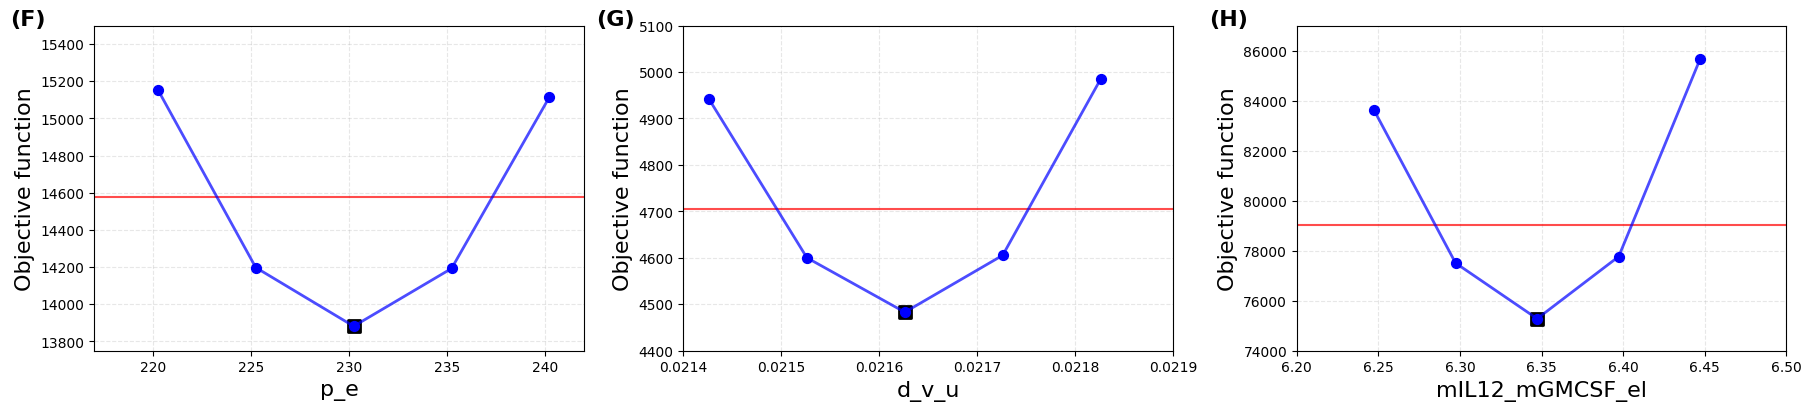

In [17]:
fig = plot_identifiability_fixed(
    excel_files=['Tables/Identifiability plots.xlsx',
                 'Tables/Identifiability plots.xlsx',
                 'Tables/Identifiability plots.xlsx'],
    sheet_names=['p_e',
                 'd_v_u',
                 'mIL12_mGMCSF_el'],
    start_param_col='Start estimation value',
    start_obj_col='Start estimation Obj. function',
    bound_line_col='Bound',
    param_values_col='Value',
    obj_values_col='Obj. function',
    xmin_col='Xmin',
    xmax_col='Xmax',
    ymin_col='Ymin',
    ymax_col='Ymax',
    ylabels=['Objective function', 'Objective function', 'Objective function'],
    ylabel_fontsize=16,
    xlabels=['p_e',
             'd_v_u',
             'mIL12_mGMCSF_el'],
    xlabel_fontsize=16,
    subplot_signs=['(F)', '(G)', '(H)'],
    n_cols=3,
    subplot_signs_fontsize=16,
    lines_colors=['blue', 'blue', 'blue']
)

# A function to visualize the optimization result for each mouse with three varying parameters: 1) <i>d_e_u</i>, 2) <i>d_m2_u</i>, and 3) <i>h_u</i> (Figure 7)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mouse_simulations(
    excel_file,
    sheet_names,
    x_col,
    exp_col,
    sim_cols,
    ncols,
    nrows,
    plot_titles,
    xlabel,
    ylabel,
    line_colors,
    subplot_width=5,
    subplot_height=4.5,
    general_title=None,
    show_parameter=None,
    indicate_parameter=None,
    top_ylim=None,
    rect_color=None,
    background_colors=None,
    lang="en",
    color_schemes=None,
    simulation_labels=None,
    sorting=None,
    legend_fontsize=10,
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    subplot_title_fontsize=14,
    exp_color=None,
    sim_colors=None,
    sim_types=None,
    legend_type="every"
):
    """
    Plots experimental and simulated data from multiple Excel sheets in a grid layout.
    All subplots share the same Y-axis scale (common maximum value).
    
    Parameters:
    ----------
    excel_file : str
        Path to Excel file containing data.
    sheet_names : list of str
        List of sheet names to plot.
    x_col : str
        Column name for X-axis data (typically time/days).
    exp_col : str
        Column name for experimental data.
    sim_cols : list of str
        List of column names containing simulated data curves.
    ncols : int
        Number of columns in the subplot grid.
    nrows : int
        Number of rows in the subplot grid.
    plot_titles : list of str
        List of titles for each subplot.
    xlabel : str
        X-axis label for all subplots.
    ylabel : str
        Y-axis label for all subplots.
    line_colors : list of str
        List of base colors for each subplot.
    subplot_width : float, optional
        Width of each subplot in inches.
    subplot_height : float, optional
        Height of each subplot in inches.
    general_title : str, optional
        Overall title for the entire figure.
    show_parameter : list of str, optional
        List of parameter strings to display in each subplot.
    indicate_parameter : list of str, optional
        List of colors for parameter display box borders.
    top_ylim : float, optional
        Fixed maximum Y-axis value for all subplots.
    rect_color : list of str, optional
        List of colors for subplot borders.
    background_colors : list of str or None, optional
        List of background colors for each subplot.
    lang : str, optional
        Language for legend labels ("en" or "ru").
    color_schemes : dict, optional
        Dictionary mapping value ranges to color schemes.
        Format: {(min_val, max_val): [line_color, background_color]}
    simulation_labels : list of str, optional
        List of labels for each simulation curve in legend.
    sorting : str, optional
        Sorting order for subplots: "ascending", "descending", or None.
    legend_fontsize : int, optional
        Font size for legend text.
    xlabel_fontsize : int, optional
        Font size for X-axis labels.
    ylabel_fontsize : int, optional
        Font size for Y-axis labels.
    subplot_title_fontsize : int, optional
        Font size for subplot titles.
    exp_color : str or list of str, optional
        Color(s) for experimental data points.
    sim_colors : list of str or list of lists, optional
        Colors for simulation curves.
    sim_types : list of str, optional
        Line styles for simulation curves ("-", "--", "-.", ":").
    legend_type : str or None, optional
        Legend display mode: "every" (each subplot), "one" (shared), or None.
    
    Returns:
    --------
    Displays the plot and prints axis scaling information.
    """
    
    # ==================== INITIAL VALIDATION ====================
    
    num_plots = len(sheet_names)
    total_subplots = nrows * ncols

    # Check if number of sheets fits in the grid
    if num_plots > total_subplots:
        raise ValueError(f"Number of sheets ({num_plots}) exceeds available subplots ({total_subplots}).")

    # Validate that sim_cols is a list
    if not isinstance(sim_cols, list):
        raise ValueError("sim_cols must be a list of column names")

    # Validate legend_type parameter
    if legend_type not in ["every", "one", None]:
        raise ValueError("Parameter legend_type must be 'every', 'one', or None")

    # Count number of simulation curves
    num_sim_curves = len(sim_cols)
    
    # ==================== SIMULATION LABELS HANDLING ====================
    
    # Handle simulation labels: generate defaults if not provided
    if simulation_labels is not None:
        if len(simulation_labels) != num_sim_curves:
            raise ValueError(f"Length of simulation_labels ({len(simulation_labels)}) doesn't match number of simulation curves ({num_sim_curves})")
    else:
        # Auto-generate labels for plot function calls (needed even if legend is hidden)
        simulation_labels = [f'Simulation {i+1}' for i in range(num_sim_curves)]

    # ==================== EXPERIMENTAL COLORS HANDLING ====================
    
    # Process exp_color parameter
    if exp_color is None:
        # If not specified, use line_colors for each plot
        exp_colors = line_colors
    elif isinstance(exp_color, str):
        # Single color for all plots
        exp_colors = [exp_color] * num_plots
    elif isinstance(exp_color, list):
        # Individual colors for each plot
        if len(exp_color) != num_plots:
            raise ValueError(f"Length of exp_color ({len(exp_color)}) doesn't match number of plots ({num_plots})")
        exp_colors = exp_color
    else:
        raise ValueError("exp_color must be a string or list of strings")

    # ==================== SIMULATION COLORS HANDLING ====================
    
    # Process sim_colors parameter for flexible color specification
    if sim_colors is None:
        # Use line_colors if no specific simulation colors provided
        sim_colors_final = None
    elif isinstance(sim_colors, list):
        # Determine if sim_colors is 1D (same for all plots) or 2D (per plot)
        if all(isinstance(item, str) for item in sim_colors):
            # 1D list: same colors for all simulation curves across all plots
            if len(sim_colors) != num_sim_curves:
                raise ValueError(f"Length of sim_colors ({len(sim_colors)}) doesn't match number of simulation curves ({num_sim_curves})")
            sim_colors_final = [sim_colors] * num_plots  # Replicate for all plots
        elif all(isinstance(item, list) for item in sim_colors):
            # 2D list: different colors for each plot
            if len(sim_colors) != num_plots:
                raise ValueError(f"Number of rows in sim_colors ({len(sim_colors)}) doesn't match number of plots ({num_plots})")
            for i, row in enumerate(sim_colors):
                if len(row) != num_sim_curves:
                    raise ValueError(f"Length of row {i} in sim_colors ({len(row)}) doesn't match number of simulation curves ({num_sim_curves})")
            sim_colors_final = sim_colors
        else:
            raise ValueError("sim_colors must be a list of strings or a list of lists of strings")
    else:
        raise ValueError("sim_colors must be a list")

    # ==================== SIMULATION LINE STYLES HANDLING ====================
    
    # Define valid line styles
    valid_line_styles = ['-', '--', '-.', ':']
    
    # Process sim_types parameter
    if sim_types is None:
        # Default: cycle through line styles, repeating if needed
        sim_types = ['-', '--', '-.', ':'][:num_sim_curves]
        if num_sim_curves > len(sim_types):
            sim_types = [valid_line_styles[i % len(valid_line_styles)] for i in range(num_sim_curves)]
    else:
        # Validate user-provided line styles
        if len(sim_types) != num_sim_curves:
            raise ValueError(f"Length of sim_types ({len(sim_types)}) doesn't match number of simulation curves ({num_sim_curves})")
        for style in sim_types:
            if style not in valid_line_styles:
                raise ValueError(f"Invalid line style '{style}'. Valid values: {valid_line_styles}")

    # ==================== VALIDATE OPTIONAL PARAMETERS ====================
    
    # Validate optional parameter list lengths match number of plots
    if show_parameter is not None and len(show_parameter) != num_plots:
        raise ValueError(f"Length of show_parameter doesn't match number of plots ({num_plots}).")
    if indicate_parameter is not None and len(indicate_parameter) != num_plots:
        raise ValueError(f"Length of indicate_parameter doesn't match number of plots ({num_plots}).")
    if rect_color is not None and len(rect_color) != num_plots:
        raise ValueError(f"Length of rect_color doesn't match number of plots ({num_plots}).")
    if background_colors is not None and len(background_colors) != num_plots:
        raise ValueError(f"Length of background_colors doesn't match number of plots ({num_plots}).")

    # Validate sorting parameter
    if sorting not in [None, "ascending", "descending"]:
        raise ValueError("Parameter sorting must be None, 'ascending' or 'descending'")

    # ==================== LANGUAGE SETUP ====================
    
    # Set experiment label based on language preference
    if lang == "en":
        experiment_label = 'Exp.'
    elif lang == "ru":
        experiment_label = 'Эксперимент'
    else:
        experiment_label = 'Exp.'  # Default to English

    # ==================== DATA LOADING AND CACHING ====================
    
    # Initialize containers for data processing
    all_y_values = []  # Collect all Y values for global axis scaling
    data_cache = {}  # Cache loaded dataframes for each sheet
    last_simulation_values = {}  # Store last simulation value for sorting/color schemes

    # Load and preprocess data from each sheet
    for sheet in sheet_names:
        try:
            df = pd.read_excel(excel_file, sheet_name=sheet)
        except ValueError as e:
            print(f"Error loading sheet '{sheet}': {e}")
            data_cache[sheet] = None
            continue

        # Clean data: drop fully empty rows
        df = df.dropna(how='all')
        
        # Convert numeric columns to appropriate types
        df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
        df[exp_col] = pd.to_numeric(df[exp_col], errors='coerce')
        
        # Convert all simulation columns to numeric
        for sim_col in sim_cols:
            df[sim_col] = pd.to_numeric(df[sim_col], errors='coerce')
        
        # Drop rows with NaN in X column
        df = df.dropna(subset=[x_col])

        # Cache the processed dataframe
        data_cache[sheet] = df

        # Extract last simulation value for sorting and color schemes
        sim_data = df.dropna(subset=[sim_cols[0]])  # Use first simulation column
        if not sim_data.empty:
            last_value = sim_data[sim_cols[0]].iloc[-1]
            last_simulation_values[sheet] = last_value
        else:
            last_simulation_values[sheet] = 0  # Default if no data

        # Collect all Y values for determining global Y-axis limits
        y_vals = [df[exp_col]] if exp_col in df.columns else []
        for sim_col in sim_cols:
            if sim_col in df.columns:
                y_vals.append(df[sim_col])
        
        # Combine all Y values and add to global collection
        if y_vals:
            all_y_df = pd.concat(y_vals, ignore_index=True)
            all_y_df = all_y_df.dropna()
            if not all_y_df.empty:
                all_y_values.extend(all_y_df)

    # ==================== Y-AXIS LIMIT CALCULATION ====================
    
    # Determine global Y-axis limits for consistent scaling across plots
    if top_ylim is not None:
        # User-specified maximum Y value
        global_ymax = top_ylim
        global_ymin = - (global_ymax * 0.05)  # 5% negative margin
    else:
        # Automatic calculation from data
        global_ymax = max(all_y_values) * 1.05 if all_y_values else None
        global_ymin = - (global_ymax * 0.05) if global_ymax is not None else -5

    # ==================== SUBPLOT SORTING ====================
    
    # Sort subplots based on last simulation values if requested
    if sorting is not None:
        # Create list of tuples with all plot data for sorting
        sorted_data = []
        for i, sheet in enumerate(sheet_names):
            last_value = last_simulation_values.get(sheet, 0)
            sorted_data.append((
                last_value,
                sheet,
                plot_titles[i],
                line_colors[i],
                show_parameter[i] if show_parameter is not None else None,
                indicate_parameter[i] if indicate_parameter is not None else None,
                rect_color[i] if rect_color is not None else None,
                background_colors[i] if background_colors is not None else None,
                exp_colors[i] if exp_colors is not None else None
            ))
        
        # Sort by last simulation value
        if sorting == "ascending":
            sorted_data.sort(key=lambda x: x[0])
        elif sorting == "descending":
            sorted_data.sort(key=lambda x: x[0], reverse=True)
        
        # Update all lists in sorted order
        sorted_last_values = [item[0] for item in sorted_data]
        sheet_names = [item[1] for item in sorted_data]
        plot_titles = [item[2] for item in sorted_data]
        line_colors = [item[3] for item in sorted_data]
        
        # Update optional parameters if they were provided
        if show_parameter is not None:
            show_parameter = [item[4] for item in sorted_data]
        if indicate_parameter is not None:
            indicate_parameter = [item[5] for item in sorted_data]
        if rect_color is not None:
            rect_color = [item[6] for item in sorted_data]
        if background_colors is not None:
            background_colors = [item[7] for item in sorted_data]
        if exp_colors is not None:
            exp_colors = [item[8] for item in sorted_data]

    # ==================== COLOR SCHEME APPLICATION ====================
    
    # Apply color schemes based on last simulation values
    final_line_colors = []
    final_background_colors = []
    
    if color_schemes is not None:
        # Apply color scheme mapping to each plot
        for i, sheet in enumerate(sheet_names):
            last_value = last_simulation_values.get(sheet, None)
            line_color = line_colors[i]  # Default color
            background_color = background_colors[i] if background_colors is not None else None
            
            # Find matching color scheme for this value
            if last_value is not None:
                for range_key, colors in color_schemes.items():
                    if len(range_key) == 2 and range_key[0] <= last_value <= range_key[1]:
                        line_color = colors[0]
                        background_color = colors[1]
                        break
            
            final_line_colors.append(line_color)
            final_background_colors.append(background_color)
    else:
        # Use original colors if no color scheme
        final_line_colors = line_colors
        final_background_colors = background_colors if background_colors is not None else [None] * num_plots

    # ==================== FIGURE CREATION ====================
    
    # Adjust figure height if using shared legend
    if legend_type == "one":
        fig_height = subplot_height * nrows + 0.8  # Extra space for legend
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                figsize=(subplot_width * ncols, fig_height))
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                figsize=(subplot_width * ncols, subplot_height * nrows))
    
    # Add overall figure title if provided
    if general_title:
        fig.suptitle(general_title, fontsize=24, fontweight='bold')

    # Handle single subplot case
    if total_subplots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # ==================== PLOT EACH SUBPLOT ====================
    
    # Initialize containers for shared legend
    legend_handles = []
    legend_labels = []

    for i in range(num_plots):
        ax = axes[i]
        sheet = sheet_names[i]
        title = plot_titles[i]
        main_line_color = final_line_colors[i]
        background_color = final_background_colors[i]
        exp_color_current = exp_colors[i]

        # Set subplot background color if specified
        if background_color is not None:
            ax.set_facecolor(background_color)

        # Get cached dataframe
        df = data_cache[sheet]
        if df is None:
            ax.set_visible(False)
            continue

        # ==================== PLOT SIMULATION CURVES ====================
        
        # Extract experimental data (remove NaN values)
        exp_data = df.dropna(subset=[exp_col]) if exp_col in df.columns else pd.DataFrame()

        # Plot all simulation curves for this sheet
        for j, sim_col in enumerate(sim_cols):
            if sim_col in df.columns:
                sim_data = df.dropna(subset=[sim_col])
                if not sim_data.empty:
                    # Determine color for this simulation curve
                    if sim_colors_final is not None:
                        # Use specified colors
                        sim_color = sim_colors_final[i][j] if isinstance(sim_colors_final[i], list) else sim_colors_final[i]
                    else:
                        # Use the main plot color
                        sim_color = main_line_color
                    
                    # Get line style
                    line_style = sim_types[j]
                    
                    # Adjust line width (thinner for additional curves)
                    line_width = 2 - (j * 0.2) if j > 0 else 2
                    
                    # Determine legend label based on legend_type
                    if legend_type is not None:
                        label = simulation_labels[j] if legend_type == "every" or (legend_type == "one" and i == 0) else None
                    else:
                        label = None
                    
                    # Plot simulation curve
                    line, = ax.plot(sim_data[x_col], sim_data[sim_col], 
                                   color=sim_color, 
                                   linestyle=line_style,
                                   linewidth=line_width,
                                   label=label)
                    
                    # Save for shared legend (only from first plot)
                    if legend_type == "one" and i == 0:
                        legend_handles.append(line)
                        legend_labels.append(simulation_labels[j])

        # ==================== PLOT EXPERIMENTAL POINTS ====================
        
        if not exp_data.empty:
            # Determine legend label
            if legend_type is not None:
                label = experiment_label if legend_type == "every" or (legend_type == "one" and i == 0) else None
            else:
                label = None
            
            # Plot experimental data points
            scatter = ax.scatter(exp_data[x_col], exp_data[exp_col], 
                               color=exp_color_current, 
                               s=30, 
                               zorder=5,
                               label=label)
            
            # Save for shared legend (only from first plot)
            if legend_type == "one" and i == 0:
                legend_handles.append(scatter)
                legend_labels.append(experiment_label)

        # ==================== AXIS AND TITLE CONFIGURATION ====================
        
        # Set subplot title and axis labels with specified font sizes
        ax.set_title(title, fontsize=subplot_title_fontsize)
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add individual legend if requested
        if legend_type == "every":
            ax.legend(fontsize=legend_fontsize)

        # ==================== Y-AXIS LIMIT ENFORCEMENT ====================
        
        # Apply consistent Y-axis limits across all subplots
        ymax = top_ylim if top_ylim is not None else global_ymax
        if ymax is not None:
            ax.set_ylim(bottom=global_ymin, top=ymax)

        # ==================== PARAMETER DISPLAY BOX ====================
        
        # Display parameter text with optional colored border
        if show_parameter is not None:
            param_text = str(show_parameter[i])
            bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            if indicate_parameter is not None:
                bbox_props['edgecolor'] = indicate_parameter[i]
                bbox_props['linewidth'] = 1.2
            ax.text(0.05, 0.95, param_text, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=bbox_props)

        # ==================== SUBPLOT BORDER COLORING ====================
        
        # Color the subplot border if specified
        if rect_color is not None:
            spine_color = rect_color[i]
            for spine in ax.spines.values():
                spine.set_color(spine_color)
                spine.set_linewidth(1)

    # ==================== HIDE EMPTY SUBPLOTS ====================
    
    # Hide any unused subplot axes
    for j in range(num_plots, total_subplots):
        axes[j].set_visible(False)

    # ==================== SHARED LEGEND CREATION ====================
    
    # Create shared legend if requested
    if legend_type == "one" and legend_handles:
        # Position legend at bottom center of figure
        fig.legend(legend_handles, legend_labels, 
                  loc='lower center', 
                  bbox_to_anchor=(0.5, 0),  # Center at bottom
                  ncol=min(len(legend_handles), 4),  # Max 4 columns
                  fontsize=legend_fontsize,
                  frameon=True,
                  fancybox=True,
                  shadow=False,
                  borderaxespad=0.5)
        
        # Adjust layout to accommodate legend
        if general_title is None:
            plt.tight_layout(rect=[0, 0.08, 1, 1])  # Reserve bottom space
        else:
            plt.tight_layout(rect=[0, 0.08, 1, 0.96])
    else:
        # Standard layout without legend space
        if general_title is None:
            plt.tight_layout()
        else:
            plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Display the complete figure
    plt.show()

    # ==================== OUTPUT AXIS INFORMATION ====================
    
    # Print axis scaling information for user reference
    if global_ymax is not None:
        if top_ylim is not None:
            print(f"User-specified top_ylim: {top_ylim}")
        else:
            print(f"Automatically determined global_ymax (with margin): {global_ymax}")
        print(f"Minimum Y-axis value: {global_ymin:.2f}")

## Figure 7 (PBS group)

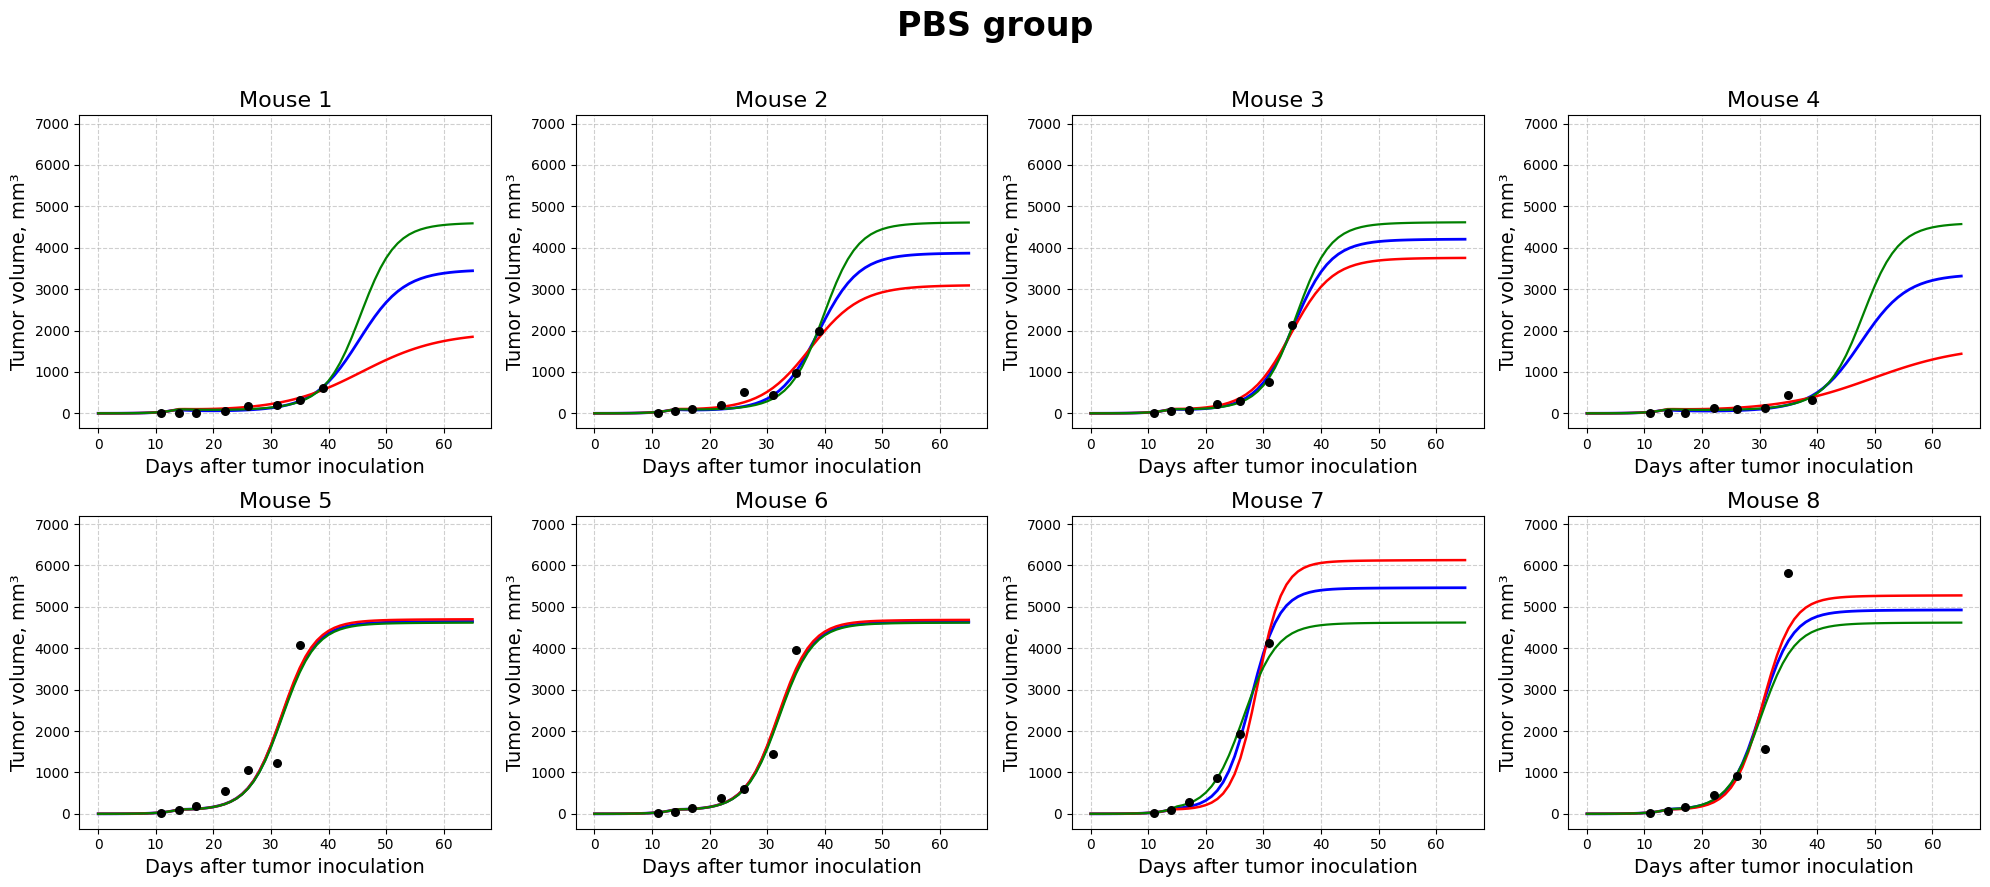

User-specified top_ylim: 7200
Minimum Y-axis value: -360.00


In [22]:
plot_mouse_simulations(
    excel_file = "Tables/Separate_mice_PBS_with_simulations.xlsx",
    sheet_names = ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8"],
    x_col = "time",
    exp_col = "Exp",
    sim_cols = ["Sim d_e_u", "Sim d_m2_u", "Sim h_u"],
    simulation_labels=["Sim. d_e_u", "Sim. d_m2_u", "Sim. h_u"],
    ncols = 4,
    nrows = 2,
    plot_titles = ["Mouse 1", "Mouse 2", "Mouse 3", "Mouse 4", "Mouse 5", "Mouse 6", "Mouse 7", "Mouse 8"],
    xlabel = "Days after tumor inoculation",
    ylabel = "Tumor volume, mm³",
    line_colors = ["black", "black", "black", "black", "black", "black", "black", "black"],
    general_title = "PBS group",
    lang="en",
    exp_color='black',
    sim_colors = ['blue', 'red', 'green'],
    sim_types = ['-', '-', '-'],
    legend_type=None,
    legend_fontsize=18,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    subplot_title_fontsize=16,
    top_ylim=7200,
    )

## Figure 7 (rVSV-GFP group)

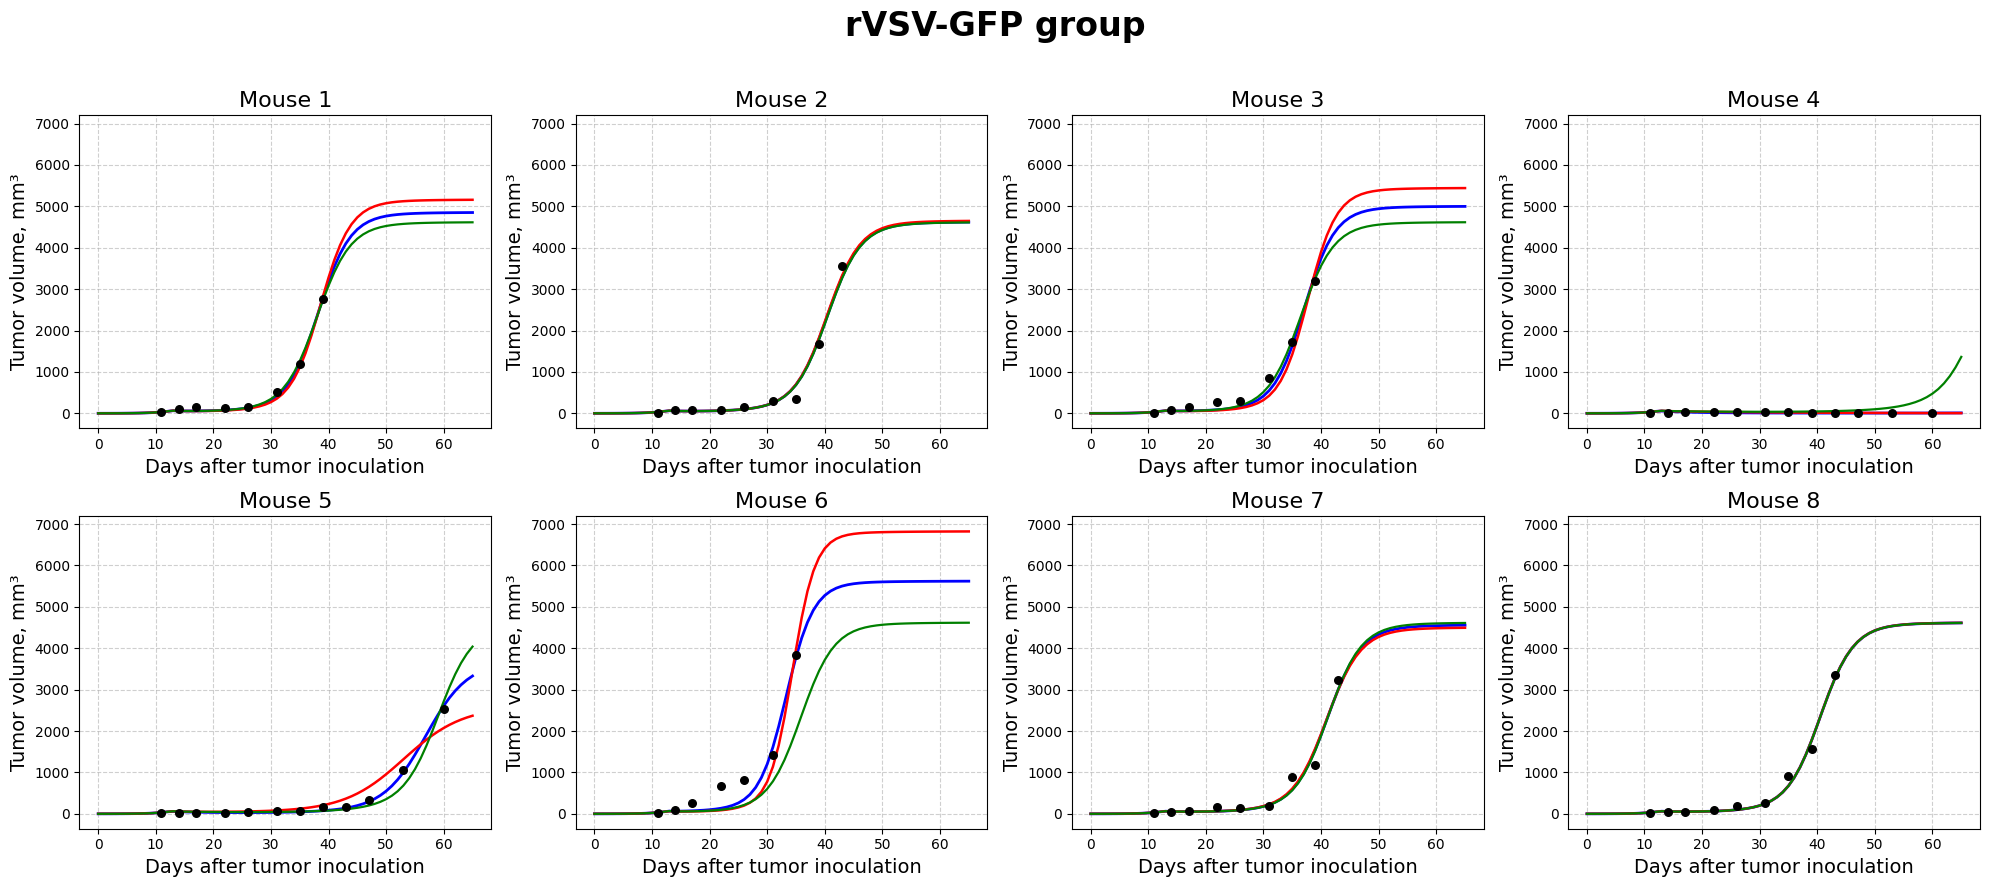

User-specified top_ylim: 7200
Minimum Y-axis value: -360.00


In [9]:
plot_mouse_simulations(
    excel_file = "Tables/Separate_mice_VSV_GFP_with_simulations.xlsx",
    sheet_names = ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8"],
    x_col = "time",
    exp_col = "Exp",
    sim_cols = ["Sim d_e_u", "Sim d_m2_u", "Sim h_u"],
    simulation_labels=["Sim. d_e_u", "Sim. d_m2_u", "Sim. h_u"],
    ncols = 4,
    nrows = 2,
    plot_titles = ["Mouse 1", "Mouse 2", "Mouse 3", "Mouse 4", "Mouse 5", "Mouse 6", "Mouse 7", "Mouse 8"],
    xlabel = "Days after tumor inoculation",
    ylabel = "Tumor volume, mm³",
    line_colors = ["black", "black", "black", "black", "black", "black", "black", "black"],
    general_title = "rVSV-GFP group",
    lang="en",
    exp_color='black',
    sim_colors = ['blue', 'red', 'green'],
    sim_types = ['-', '-', '-'],
    legend_type=None,
    legend_fontsize=18,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    subplot_title_fontsize=16,
    top_ylim=7200,
    )

## Figure 7 (rVSV-mIL12-mGMCSF group)

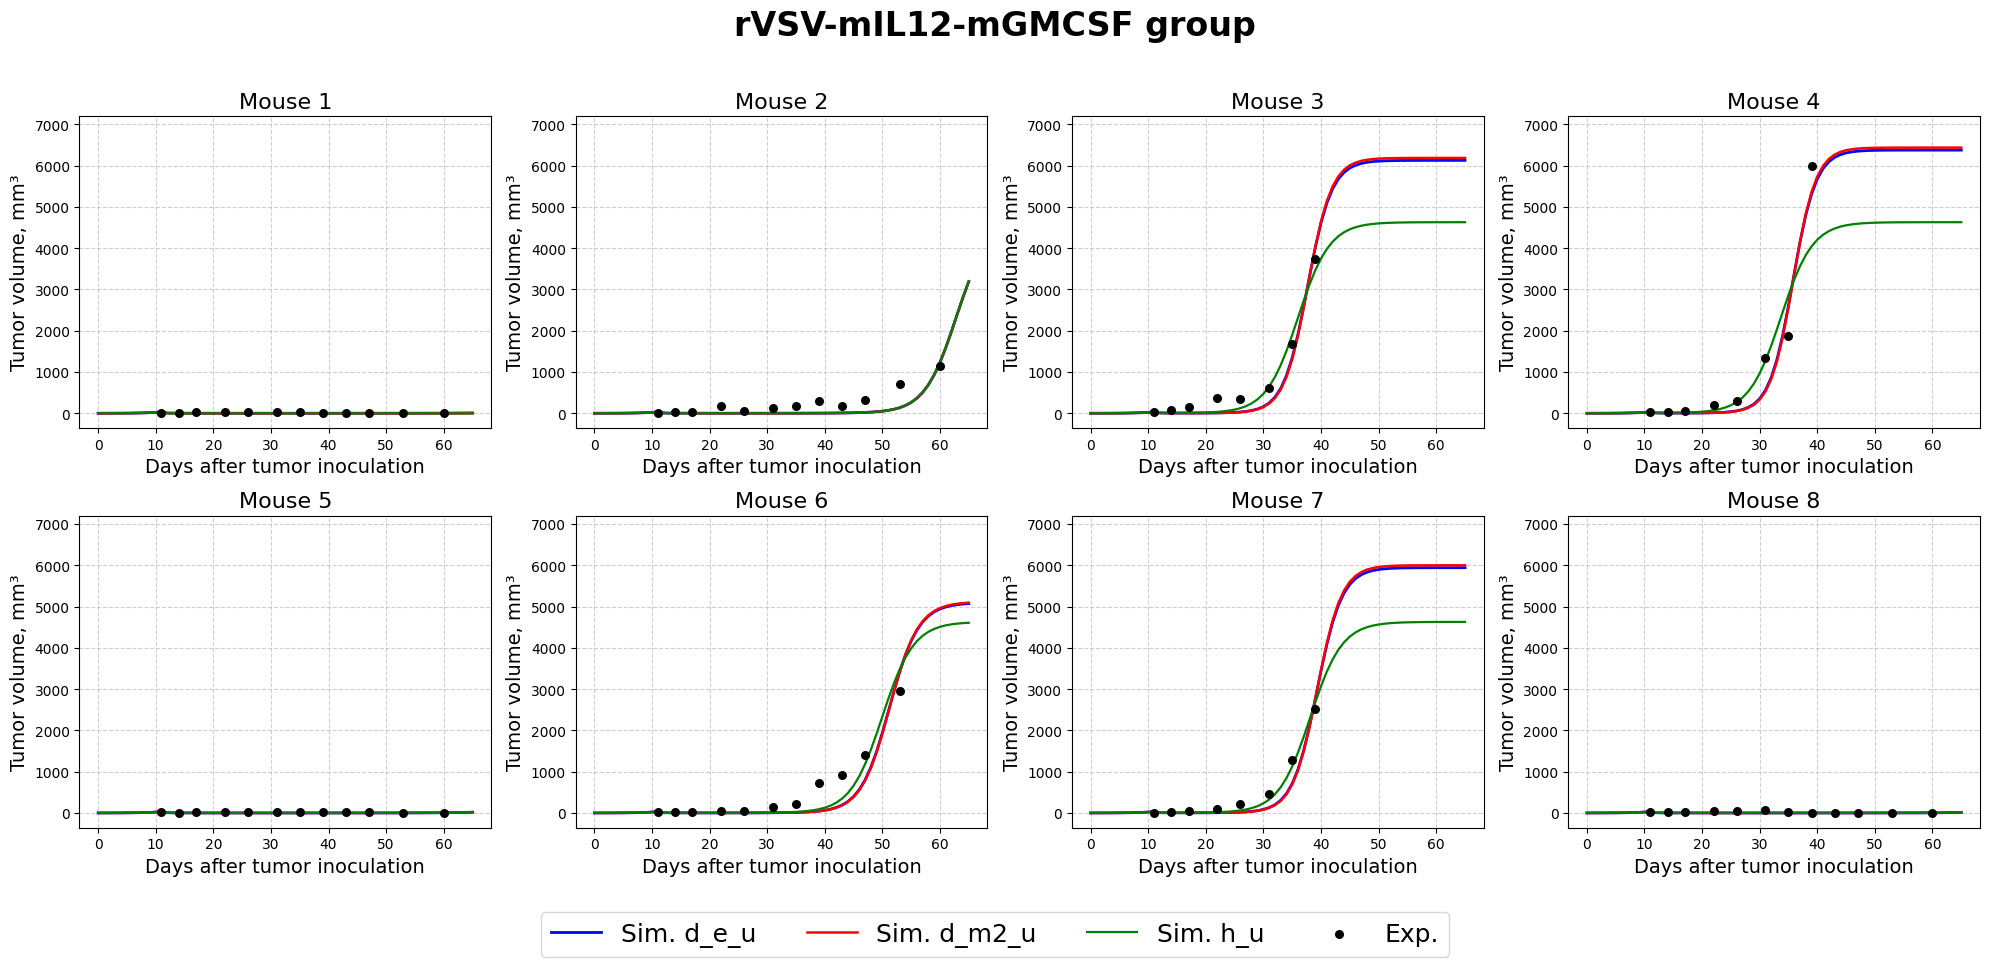

User-specified top_ylim: 7200
Minimum Y-axis value: -360.00


In [10]:
plot_mouse_simulations(
    excel_file = "Tables/Separate_mice_VSV_mIL12_mGMCSF_with_simulations.xlsx",
    sheet_names = ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8"],
    x_col = "time",
    exp_col = "Exp",
    sim_cols = ["Sim d_e_u", "Sim d_m2_u", "Sim h_u"],
    simulation_labels=["Sim. d_e_u", "Sim. d_m2_u", "Sim. h_u"],
    ncols = 4,
    nrows = 2,
    plot_titles = ["Mouse 1", "Mouse 2", "Mouse 3", "Mouse 4", "Mouse 5", "Mouse 6", "Mouse 7", "Mouse 8"],
    xlabel = "Days after tumor inoculation",
    ylabel = "Tumor volume, mm³",
    line_colors = ["black", "black", "black", "black", "black", "black", "black", "black"],
    general_title = "rVSV-mIL12-mGMCSF group",
    lang="en",
    exp_color='black',
    sim_colors = ['blue', 'red', 'green'],
    sim_types = ['-', '-', '-'],
    legend_type="one",
    legend_fontsize=18,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    subplot_title_fontsize=16,
    top_ylim=7200,
    )

# A function to visualize the quality of the experimental data approximation for each mouse using three varying parameters: 1) <i>d_e_u</i>, 2) <i>d_m2_u</i>, and 3) <i>h_u</i> (Figure 8)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook
import math

def create_grouped_bar_chart(
    file: str,
    sheet: str,
    title: str = None,
    title_fontsize: int = 14,
    x_axis_label: str = "",
    x_axis_label_fontsize: int = 12,
    y_axis_label: str = "",
    y_axis_label_fontsize: int = 12,
    y_axis_type: str = "number",
    legend_fontsize: int = 10,
    group_titles: list = None,
    group_titles_fontsize: int = 11,
    legend_title=None,
    bars_colors: list = None,
    show_values: bool = True,
    legend_labels: list = None
):
    """
    Creates a grouped bar chart from data in an Excel file.
    
    This function reads data from an Excel worksheet where:
    - First row (excluding first column) contains group/category names
    - First column contains sample/bar names
    - Data cells contain numerical values
    
    The chart groups bars by categories (columns in Excel) and shows
    multiple bars per category representing different samples (rows in Excel).
    
    Parameters:
    -----------
    file : str
        Path to Excel file
    sheet : str
        Sheet name within Excel file
    title : str, optional
        Chart title
    title_fontsize : int
        Font size for chart title
    x_axis_label : str
        Label for X-axis
    x_axis_label_fontsize : int
        Font size for X-axis label
    y_axis_label : str
        Label for Y-axis
    y_axis_label_fontsize : int
        Font size for Y-axis label
    y_axis_type : str
        Y-axis scale type: "number" (linear) or "log10" (logarithmic)
    legend_fontsize : int
        Font size for legend
    group_titles : list, optional
        Custom names for X-axis groups (overrides category names from file)
    group_titles_fontsize : int
        Font size for group titles on X-axis
    bars_colors : list, optional
        Colors for each sample's bars
    show_values : bool
        Whether to display values above bars
    legend_labels : list, optional
        Custom labels for legend (overrides sample names from file)
    """
    
    # ==================== EXCEL DATA LOADING AND PARSING ====================
    
    try:
        # Load Excel workbook using openpyxl for cell-level access
        wb = load_workbook(file, data_only=True)  # data_only=True gets calculated values, not formulas
        ws = wb[sheet]  # Access specific worksheet
        
        # Initialize data structures
        data = []  # Main data matrix
        row_labels = []  # Sample names (from first column)
        column_labels = []  # Category names (from first row)
        
        # ==================== EXTRACT COLUMN HEADERS ====================
        
        # Read category names from first row, starting from second column
        # First column (column 1) typically contains sample names
        for col in range(2, ws.max_column + 1):
            cell = ws.cell(row=1, column=col)
            if cell.value:
                column_labels.append(str(cell.value))
        
        # ==================== EXTRACT ROW LABELS ====================
        
        # Read sample names from first column, starting from second row
        # First row (row 1) typically contains category names
        for row in range(2, ws.max_row + 1):
            cell = ws.cell(row=row, column=1)
            if cell.value:
                row_labels.append(str(cell.value))
        
        # ==================== EXTRACT DATA VALUES ====================
        
        # Read numerical data from worksheet
        for row in range(2, ws.max_row + 1):
            row_data = []
            for col in range(2, ws.max_column + 1):
                cell = ws.cell(row=row, column=col)
                value = cell.value
                
                # Convert value to float if possible, otherwise use 0
                try:
                    if value is not None:
                        row_data.append(float(value))
                    else:
                        row_data.append(0)
                except (ValueError, TypeError):
                    row_data.append(0)
            
            data.append(row_data)
        
        # Check if any data was loaded
        if not data:
            print("No data available for chart creation")
            return
        
        # ==================== DATA TRANSPOSITION ====================
        
        # Transpose data: original columns become groups, original rows become bars within groups
        # This prepares data for grouped bar chart format
        data_transposed = []
        
        # For each category (original column), collect values across all samples
        for col_idx in range(len(data[0])):  # Iterate through categories
            category_data = []
            for row_idx in range(len(data)):  # Iterate through samples
                category_data.append(data[row_idx][col_idx])
            data_transposed.append(category_data)
        
        # ==================== CREATE PANDAS DATAFRAME ====================
        
        # Create DataFrame with:
        # - Rows: categories (column_labels)
        # - Columns: samples (row_labels)
        # - Values: numerical data
        df = pd.DataFrame(
            data_transposed, 
            index=column_labels[:len(data_transposed)],  # Categories as row indices
            columns=row_labels[:len(data_transposed[0])] if data_transposed else []  # Samples as column names
        )
        
    except Exception as e:
        print(f"Error loading file: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # Debug output showing data structure
    print("Loaded data (transposed):")
    print(df)
    print(f"\nGroups (categories): {df.index.tolist()}")
    print(f"Bars within groups (samples): {df.columns.tolist()}")
    
    # ==================== CHART SETUP AND CONFIGURATION ====================
    
    # Create figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Calculate chart dimensions
    n_groups = len(df)  # Number of groups/categories
    n_bars_per_group = len(df.columns)  # Number of bars within each group
    
    # Calculate bar width based on number of bars per group
    bar_width = 0.8 / n_bars_per_group  # Total group width is 0.8, divided by bars per group
    
    # Create position indices for groups along X-axis
    index = np.arange(n_groups)
    
    # ==================== COLOR CONFIGURATION ====================
    
    # Set colors for each sample's bars
    if bars_colors is not None:
        if len(bars_colors) >= n_bars_per_group:
            colors = bars_colors[:n_bars_per_group]  # Use provided colors
        else:
            # Extend provided colors with default color palette if insufficient
            default_colors = plt.cm.Set3(np.linspace(0, 1, n_bars_per_group - len(bars_colors)))
            colors = bars_colors + list(default_colors)
    else:
        # Use default color palette if no colors provided
        colors = plt.cm.Set3(np.linspace(0, 1, n_bars_per_group))
    
    # ==================== LEGEND LABELS CONFIGURATION ====================
    
    # Determine legend labels: use custom if provided, otherwise use sample names
    if legend_labels is not None and len(legend_labels) >= n_bars_per_group:
        legend_labels_to_use = legend_labels[:n_bars_per_group]
    else:
        legend_labels_to_use = df.columns.tolist()  # Default to sample names
    
    # ==================== BAR PLOTTING LOOP ====================
    
    # Store bar objects for reference
    bars = []
    
    # Plot bars for each sample across all groups
    for i, sample_name in enumerate(df.columns):
        # Extract values for this sample across all groups
        sample_data = df[sample_name].values
        
        # Calculate positions for this sample's bars within each group
        # Center bars within group: offset based on bar index, then center adjustment
        bar_positions = index + i * bar_width - (bar_width * (n_bars_per_group - 1) / 2)
        
        # Plot bars for this sample
        bar = ax.bar(bar_positions, sample_data, bar_width, 
                    label=legend_labels_to_use[i], color=colors[i], 
                    edgecolor='black', linewidth=0.5)
        bars.append(bar)
        
        # ==================== VALUE ANNOTATION ====================
        
        # Add value labels above bars if requested
        if show_values:
            for rect, value in zip(bar, sample_data):
                height = value
                if height > 0:
                    # Format value based on magnitude
                    if y_axis_type == 'log10' and height > 0:
                        # Scientific notation for logarithmic scale
                        label = f"{height:.1e}"
                    else:
                        # Smart formatting based on value magnitude
                        if height >= 1_000_000:
                            label = f"{height/1_000_000:.1f}M"  # Millions
                        elif height >= 1_000:
                            label = f"{height/1_000:.1f}k"  # Thousands
                        elif height >= 0.01 and height < 1:
                            label = f"{height:.3f}"  # Small decimals
                        else:
                            label = f"{height:.0f}"  # Regular numbers
                    
                    # Determine vertical alignment and position
                    va = 'bottom'
                    y_pos = height
                    
                    # Adjust position for logarithmic scale
                    if y_axis_type == 'log10':
                        y_pos = height * 1.05  # Slightly above bar
                        va = 'bottom'
                    
                    # Adjust for very small values on linear scale
                    if y_axis_type != 'log10' and height < ax.get_ylim()[1] * 0.05:
                        y_pos = height * 1.2  # Higher for visibility
                        va = 'bottom'
                    
                    # Add text annotation
                    ax.text(rect.get_x() + rect.get_width()/2., y_pos,
                           label, ha='center', va=va, fontsize=8,
                           fontweight='bold')
    
    # ==================== AXIS CONFIGURATION ====================
    
    # Configure X-axis
    ax.set_xlabel(x_axis_label, fontsize=x_axis_label_fontsize)
    ax.set_xticks(index)  # Place ticks at group centers
    
    # Set X-axis tick labels (group titles)
    # Rotate 45 degrees for better readability with long labels
    if group_titles is not None and len(group_titles) >= n_groups:
        ax.set_xticklabels(group_titles[:n_groups], rotation=45, ha='right', 
                          fontsize=group_titles_fontsize)
    else:
        # Use category names from DataFrame index
        ax.set_xticklabels(df.index, rotation=45, ha='right', 
                          fontsize=group_titles_fontsize)
    
    # Configure Y-axis
    ax.set_ylabel(y_axis_label, fontsize=y_axis_label_fontsize)
    
    # Set Y-axis scale type and limits
    if y_axis_type == 'log10':
        ax.set_yscale('log')  # Set logarithmic scale
        
        # Ensure no zero or negative values for log scale
        positive_values = df.values[df.values > 0]
        if len(positive_values) > 0:
            y_min = positive_values.min() * 0.1  # 10% below minimum positive value
        else:
            y_min = 0.1  # Default minimum
        y_max = df.values.max() * 10  # 10x above maximum value
        ax.set_ylim(y_min, y_max)
    else:
        # Linear scale: adjust y-limits to accommodate value labels
        if show_values:
            y_max = df.values.max()
            # Increase upper limit to make room for value labels (increased to 1.25 for rotated labels)
            ax.set_ylim(0, y_max * 1.25)
    
    # ==================== TITLE AND LEGEND ====================
    
    # Add chart title if provided
    if title:
        ax.set_title(title, fontsize=title_fontsize, pad=20)
    
    # Add legend with custom labels
    ax.legend(fontsize=legend_fontsize, loc='best', title=legend_title)
    
    # ==================== GRID AND LAYOUT ====================
    
    # Add horizontal grid lines for better readability
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # Adjust bottom margin to accommodate rotated X-axis labels
    plt.subplots_adjust(bottom=0.15)
    
    # Automatically adjust layout to prevent element clipping
    plt.tight_layout()
    
    # Display the chart
    plt.show()
    
    # Return figure, axis, and DataFrame for further manipulation if needed
    return fig, ax, df

## Figure 8

Loaded data (transposed):
                      OFV_d_e_u     OFV_d_m2_u        OFV_h_u
PBS               142115.428018  138406.810439  155323.281610
VSV-GFP            49450.434094   98891.953812  406521.440905
VSV-mIL12-mGMCSF  259221.484694  262056.317981  268080.236103
Total             450787.346807  499355.082231  829924.958618

Groups (categories): ['PBS ', 'VSV-GFP', 'VSV-mIL12-mGMCSF', 'Total']
Bars within groups (samples): ['OFV_d_e_u', 'OFV_d_m2_u', 'OFV_h_u']


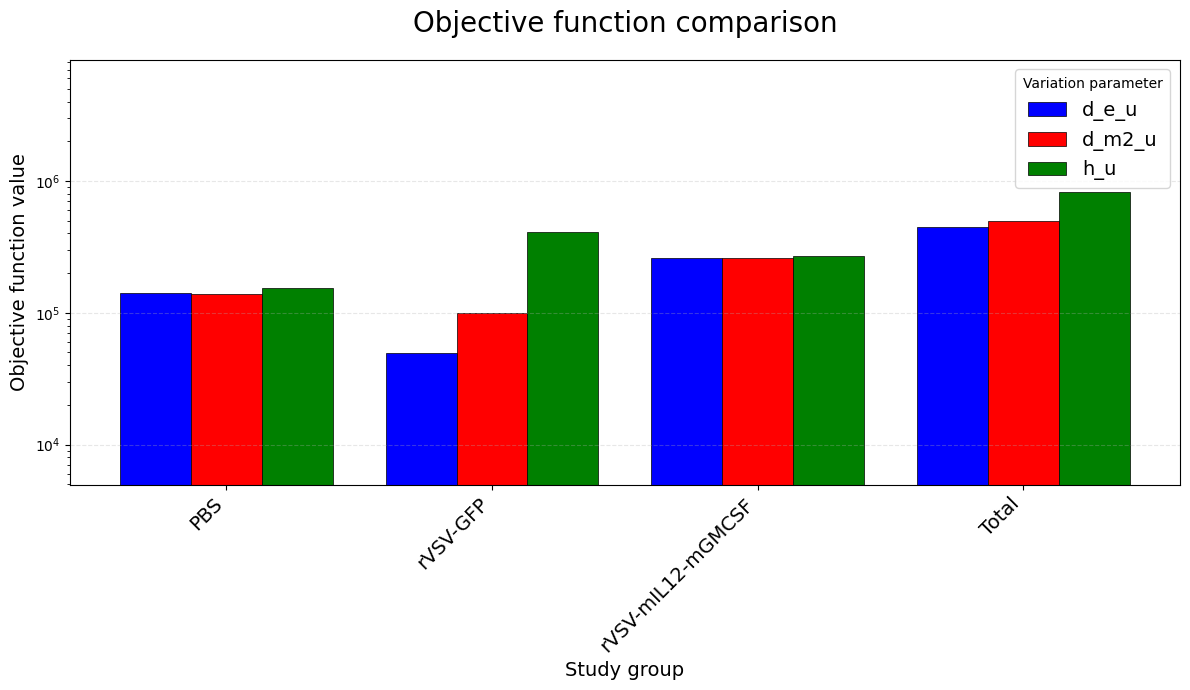

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Objective function comparison'}, xlabel='Study group', ylabel='Objective function value'>,
                       OFV_d_e_u     OFV_d_m2_u        OFV_h_u
 PBS               142115.428018  138406.810439  155323.281610
 VSV-GFP            49450.434094   98891.953812  406521.440905
 VSV-mIL12-mGMCSF  259221.484694  262056.317981  268080.236103
 Total             450787.346807  499355.082231  829924.958618)

In [13]:
create_grouped_bar_chart(
        file="Tables/OFV.xlsx",
        sheet="Лист1",
        title="Objective function comparison",
        title_fontsize=20,
        x_axis_label="Study group",
        x_axis_label_fontsize=14,
        y_axis_label="Objective function value",
        y_axis_label_fontsize=14,
        y_axis_type="log10",
        legend_fontsize=14,
        group_titles=["PBS", "rVSV-GFP", "rVSV-mIL12-mGMCSF", "Total"],
        group_titles_fontsize=14,
        show_values=False,
        bars_colors=['blue', 'red', 'green', 'magenta'],
        legend_labels=['d_e_u', 'd_m2_u', 'h_u'],
        legend_title='Variation parameter'
    )

# A function to visualize the comparison of the experimental and simulated Kaplan-Meier curves for the treatment with VSV-GFP and VSV-mIL12-mGMCSF (Figure 9)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_kaplan_meier_survival(
    files,
    lists,
    x_cols,
    exp_cols,
    sim_cols,
    titles,
    title_fontsizes,
    y_labels,
    y_label_fontsizes,
    x_labels,
    x_label_fontsizes,
    figsize_of_subplot=(6, 4),
    thresholds=2000,
    x_values_list=None,
    line_designs='diagonal',
    plot_signs=None,
    n_cols=1,
    legend_type='every',
    legend_fontsize=10
):
    """
    Plots Kaplan-Meier survival curves for experimental and simulated groups.
    Can plot multiple survival curves from different files in a single figure.
    
    Survival calculation algorithm for each plot:
    1. For each time point in x_values (or all available if x_values=None):
    2. Experimental group: mouse is alive if data EXISTS (even if value = 0)
    3. Simulated group: mouse is alive if tumor size <= threshold
    4. Survival rate = (alive mice) / (total mice in study) * 100%
    
    Parameters:
    ----------
    files : str or list of str
        Path to file or list of file paths
    
    lists : list of lists
        List of sheet name lists for each plot
        
    x_cols : str or list of str
        Column name(s) for time data
    
    exp_cols : str or list of str
        Column name(s) for experimental data
    
    sim_cols : str or list of str
        Column name(s) for simulated data
    
    thresholds : int or list of int
        Threshold value for death in simulated group
    
    x_values_list : list of arrays or array or None
        List of x-value arrays for survival calculation
    
    line_designs : str or list of str
        - 'diagonal': curve connects points with diagonal lines
        - 'orthogonal': curve uses horizontal then vertical steps (step function)
    
    plot_signs : list of str, optional
        Labels for plots (displayed in top-left corner of each plot)
    
    n_cols : int
        Number of plots per row
        
    legend_type : str
        - 'every': legend displayed on each subplot
        - 'one': single legend displayed below all plots
        
    legend_fontsize : int
        Font size for legend text
    """
    
    # ==================== PARAMETER VALIDATION AND PREPROCESSING ====================
    
    # Determine number of plots from the lists parameter
    n_plots = len(lists)
    
    # Validate legend_type parameter
    if legend_type not in ['every', 'one']:
        raise ValueError("legend_type must be 'every' or 'one'")
    
    # Convert scalar parameters to lists for uniform processing
    # File paths handling
    if isinstance(files, str):
        files = [files] * n_plots  # Same file for all plots
    elif len(files) != n_plots:
        files = [files[0]] * n_plots  # Use first file for all plots if count doesn't match
    
    # Column names handling
    if isinstance(x_cols, str):
        x_cols = [x_cols] * n_plots
    elif len(x_cols) != n_plots:
        x_cols = [x_cols[0]] * n_plots
    
    if isinstance(exp_cols, str):
        exp_cols = [exp_cols] * n_plots
    elif len(exp_cols) != n_plots:
        exp_cols = [exp_cols[0]] * n_plots
    
    if isinstance(sim_cols, str):
        sim_cols = [sim_cols] * n_plots
    elif len(sim_cols) != n_plots:
        sim_cols = [sim_cols[0]] * n_plots
    
    # Text and formatting parameters
    if not isinstance(titles, list):
        titles = [titles] * n_plots
    if not isinstance(title_fontsizes, list):
        title_fontsizes = [title_fontsizes] * n_plots
    if not isinstance(y_labels, list):
        y_labels = [y_labels] * n_plots
    if not isinstance(y_label_fontsizes, list):
        y_label_fontsizes = [y_label_fontsizes] * n_plots
    if not isinstance(x_labels, list):
        x_labels = [x_labels] * n_plots
    if not isinstance(x_label_fontsizes, list):
        x_label_fontsizes = [x_label_fontsizes] * n_plots
    if not isinstance(thresholds, list):
        thresholds = [thresholds] * n_plots
    if not isinstance(line_designs, list):
        line_designs = [line_designs] * n_plots
    
    # ==================== EXCEL FILE LOADING ====================
    
    # Load all Excel files once to avoid redundant file operations
    xls_files = {}
    for file_path in set(files):  # Use set to avoid loading same file multiple times
        try:
            xls_files[file_path] = pd.ExcelFile(file_path)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            xls_files[file_path] = None
    
    # ==================== FIGURE AND SUBPLOT SETUP ====================
    
    # Calculate grid dimensions
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division for rows
    figsize_per_plot = figsize_of_subplot
    total_width = figsize_per_plot[0] * n_cols
    total_height = figsize_per_plot[1] * n_rows
    
    # Create figure with adjusted height for shared legend
    if legend_type == 'one':
        # Adjust figure height to accommodate legend at bottom
        height_ratio = 0.9  # 90% for plots, 10% for legend
        total_height_with_legend = total_height / height_ratio
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(total_width, total_height_with_legend),
                                squeeze=False,
                                constrained_layout=False)  # Manual layout control for legend spacing
    else:
        fig, axes = plt.subplots(n_rows, ncols=n_cols, 
                                figsize=(total_width, total_height),
                                squeeze=False,
                                constrained_layout=True)
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten()
    
    # Initialize containers for shared legend elements
    legend_handles = None
    legend_labels = None
    
    # ==================== MAIN PLOTTING LOOP ====================
    
    for plot_idx in range(n_plots):
        ax = axes_flat[plot_idx]
        
        # ==================== PARAMETER EXTRACTION FOR CURRENT PLOT ====================
        
        # Extract all parameters for current plot using list indexing
        current_file = files[plot_idx]
        current_lists = lists[plot_idx]
        current_x_col = x_cols[plot_idx]
        current_exp_col = exp_cols[plot_idx]
        current_sim_col = sim_cols[plot_idx]
        current_title = titles[plot_idx] if plot_idx < len(titles) else f"Plot {plot_idx+1}"
        current_title_fontsize = title_fontsizes[plot_idx] if plot_idx < len(title_fontsizes) else 14
        current_y_label = y_labels[plot_idx] if plot_idx < len(y_labels) else "Survival Rate"
        current_y_label_fontsize = y_label_fontsizes[plot_idx] if plot_idx < len(y_label_fontsizes) else 12
        current_x_label = x_labels[plot_idx] if plot_idx < len(x_labels) else "Time"
        current_x_label_fontsize = x_label_fontsizes[plot_idx] if plot_idx < len(x_label_fontsizes) else 12
        current_threshold = thresholds[plot_idx] if plot_idx < len(thresholds) else 2000
        current_line_design = line_designs[plot_idx] if plot_idx < len(line_designs) else 'diagonal'
        current_plot_sign = plot_signs[plot_idx] if plot_signs and plot_idx < len(plot_signs) else None
        
        # Extract x-values for survival calculation
        if x_values_list is not None:
            if isinstance(x_values_list, list):
                current_x_values = x_values_list[plot_idx] if plot_idx < len(x_values_list) else None
            else:
                current_x_values = x_values_list  # Same array for all plots
        else:
            current_x_values = None  # Will be determined from data
        
        # ==================== FILE AVAILABILITY CHECK ====================
        
        # Check if file is loaded successfully
        if current_file not in xls_files or xls_files[current_file] is None:
            ax.text(0.5, 0.5, f"File not found\n{current_file}", 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='red')
            continue
        
        # ==================== LINE DESIGN VALIDATION ====================
        
        # Validate line_design parameter
        if current_line_design not in ['diagonal', 'orthogonal']:
            ax.text(0.5, 0.5, f"Error: line_design must be 'diagonal' or 'orthogonal'", 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=10, color='red')
            continue
        
        # ==================== TIME POINT COLLECTION ====================
        
        # Collect all time points from data if not explicitly provided
        if current_x_values is None:
            all_time_points = set()
            for sheet_name in current_lists:
                if sheet_name not in xls_files[current_file].sheet_names:
                    continue  # Skip if sheet doesn't exist
                
                try:
                    df = pd.read_excel(xls_files[current_file], sheet_name=sheet_name)
                    if current_x_col in df.columns:
                        # Extract unique time values from column
                        time_vals = df[current_x_col].dropna().unique()
                        all_time_points.update(time_vals)
                except Exception as e:
                    print(f"Error reading sheet '{sheet_name}' from file '{current_file}': {e}")
                    continue
            
            # Check if any time points were found
            if not all_time_points:
                ax.text(0.5, 0.5, f"No time points found", 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='red')
                continue
            
            # Sort time points for consistent plotting
            current_x_values = sorted(all_time_points)
        else:
            # Convert provided x_values to list
            current_x_values = list(current_x_values)
        
        # ==================== DATA STRUCTURES INITIALIZATION ====================
        
        # Initialize dictionaries to store survival data per time point
        exp_survival_data = {}  # Experimental group survival status
        sim_survival_data = {}  # Simulated group survival status
        
        # Pre-initialize data structures for all time points
        for time in current_x_values:
            exp_survival_data[time] = []  # List of 1/0 values for each mouse
            sim_survival_data[time] = []
        
        # ==================== DATA PROCESSING PER MOUSE ====================
        
        # Process each mouse (each Excel sheet represents one mouse)
        for sheet_name in current_lists:
            
            # Skip if sheet doesn't exist in file
            if sheet_name not in xls_files[current_file].sheet_names:
                continue
            
            # Load data for this mouse
            try:
                df = pd.read_excel(xls_files[current_file], sheet_name=sheet_name)
            except Exception as e:
                print(f"Error reading sheet '{sheet_name}' from file '{current_file}': {e}")
                continue
            
            # Check for required columns
            required_cols = [current_x_col, current_exp_col, current_sim_col]
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                print(f"Warning: Sheet '{sheet_name}' missing columns: {missing_cols}")
                continue
            
            # ==================== DATA DICTIONARY CREATION ====================
            
            # Create dictionary for quick data access by time point
            time_data = {}
            for i, row in df.iterrows():
                time_val = row[current_x_col]
                if pd.isna(time_val):
                    continue  # Skip rows with NaN time values
                
                # Ensure time value matches the type of x_values (for comparison)
                try:
                    time_val = type(current_x_values[0])(time_val) if current_x_values else time_val
                except (ValueError, TypeError):
                    pass  # Keep original type if conversion fails
                
                # Only include time points that are in our analysis set
                if time_val in current_x_values:
                    exp_val = row[current_exp_col]
                    sim_val = row[current_sim_col]
                    time_data[time_val] = (exp_val, sim_val)  # Store both experimental and simulated values
            
            # ==================== SURVIVAL STATUS DETERMINATION ====================
            
            # Determine survival status for each time point in analysis set
            for time in current_x_values:
                if time in time_data:
                    # Mouse has data at this time point
                    exp_val, sim_val = time_data[time]
                    
                    # Experimental group: mouse is alive if data EXISTS (even if value is 0)
                    exp_alive = 1 if not pd.isna(exp_val) else 0
                    
                    # Simulated group: mouse is alive if tumor size <= threshold
                    sim_alive = 1 if not pd.isna(sim_val) and sim_val <= current_threshold else 0
                else:
                    # Mouse has no data at this time point - apply censoring rules
                    
                    # Find previous time points where data was available
                    prev_times = [t for t in current_x_values if t < time and t in time_data]
                    prev_times_sorted = sorted(prev_times, reverse=True)  # Most recent first
                    
                    # Default: assume mouse is alive unless proven otherwise
                    exp_alive = 1
                    sim_alive = 1
                    
                    # Check if mouse was previously censored in experimental group
                    for prev_time in prev_times_sorted:
                        if prev_time in time_data:
                            prev_exp_val, _ = time_data[prev_time]
                            
                            # If mouse had no experimental data at previous time, it's censored
                            exp_alive = 0
                            break
                        else:
                            continue  # No data at this previous time, check earlier times
                    
                    # Check if mouse died previously in simulated group
                    for prev_time in prev_times_sorted:
                        if prev_time in time_data:
                            _, prev_sim_val = time_data[prev_time]
                            
                            # If tumor size exceeded threshold at previous time, mouse died
                            if not pd.isna(prev_sim_val) and prev_sim_val > current_threshold:
                                sim_alive = 0
                                break
                
                # Store survival status for this mouse at this time
                exp_survival_data[time].append(exp_alive)
                sim_survival_data[time].append(sim_alive)
        
        # ==================== SURVIVAL RATE CALCULATION ====================
        
        # Calculate survival rates for each time point
        exp_survival_rates = []
        sim_survival_rates = []
        
        for time in current_x_values:
            exp_statuses = exp_survival_data.get(time, [])
            sim_statuses = sim_survival_data.get(time, [])
            
            # Skip time points with no data for any mouse
            if not exp_statuses or not sim_statuses:
                continue
            
            # Count alive mice (sum of 1's in status list)
            exp_alive_count = sum(exp_statuses)
            sim_alive_count = sum(sim_statuses)
            
            # Number of mice still in study (not yet censored/died)
            active_mice_exp = len(exp_statuses)
            active_mice_sim = len(sim_statuses)
            
            # Calculate survival rates as percentages
            exp_survival_rate = (exp_alive_count / active_mice_exp) * 100 if active_mice_exp > 0 else 0
            sim_survival_rate = (sim_alive_count / active_mice_sim) * 100 if active_mice_sim > 0 else 0
            
            exp_survival_rates.append(exp_survival_rate)
            sim_survival_rates.append(sim_survival_rate)
        
        # ==================== DATA VALIDATION ====================
        
        # Filter to only include time points with valid data
        valid_times = [time for i, time in enumerate(current_x_values) 
                      if i < len(exp_survival_rates) and i < len(sim_survival_rates)]
        
        # Check if any valid data exists
        if not valid_times:
            ax.text(0.5, 0.5, f"No data for analysis", 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='red')
            continue
        
        # ==================== SURVIVAL CURVE CONSTRUCTION ====================
        
        # Add starting point: time 0, 100% survival
        all_times = [0] + valid_times
        all_exp_rates = [100] + exp_survival_rates
        all_sim_rates = [100] + sim_survival_rates
        
        # ==================== PLOTTING BASED ON LINE DESIGN ====================
        
        if current_line_design == 'diagonal':
            # Connect points with straight lines (standard KM curve)
            
            # Plot experimental group with solid blue line and circle markers
            exp_line, = ax.plot(all_times, all_exp_rates, 'b-', linewidth=3, 
                                label='Experimental Group', marker='o', markersize=6)
            
            # Plot simulated group with dashed red line and square markers
            sim_line, = ax.plot(all_times, all_sim_rates, 'r--', linewidth=3, 
                                label='Simulated Group', marker='s', markersize=6)
            
            # Store handles for shared legend (only from first plot)
            if legend_type == 'one' and plot_idx == 0:
                legend_handles = [exp_line, sim_line]
                legend_labels = ['Experimental Group', 'Simulated Group']
        
        elif current_line_design == 'orthogonal':
            # Create step function (horizontal then vertical lines)
            
            def create_step_line(times, values):
                """Convert point data to step function coordinates"""
                step_times = []
                step_values = []
                
                for i in range(len(times)):
                    if i > 0:
                        # Horizontal segment at previous value
                        step_times.append(times[i-1])
                        step_values.append(values[i-1])
                        # Vertical drop to new value
                        step_times.append(times[i])
                        step_values.append(values[i-1])
                    
                    # Point at new value
                    step_times.append(times[i])
                    step_values.append(values[i])
                
                return step_times, step_values
            
            # Create step function coordinates for both groups
            exp_step_times, exp_step_values = create_step_line(all_times, all_exp_rates)
            sim_step_times, sim_step_values = create_step_line(all_times, all_sim_rates)
            
            # Plot step functions
            exp_line, = ax.plot(exp_step_times, exp_step_values, 'b-', linewidth=3, 
                                label='Experimental Group')
            sim_line, = ax.plot(sim_step_times, sim_step_values, 'r--', linewidth=3, 
                                label='Simulated Group')
            
            # Add markers at original data points
            ax.plot(all_times, all_exp_rates, 'bo', markersize=6, markerfacecolor='b')
            ax.plot(all_times, all_sim_rates, 'rs', markersize=6, markerfacecolor='r')
            
            # Store handles for shared legend
            if legend_type == 'one' and plot_idx == 0:
                legend_handles = [exp_line, sim_line]
                legend_labels = ['Experimental Group', 'Simulated Group']
        
        # ==================== AXIS AND LABEL CONFIGURATION ====================
        
        # Set plot title with specified font size
        ax.set_title(current_title, fontsize=current_title_fontsize, fontweight='bold')
        
        # Set axis labels with specified font sizes
        ax.set_xlabel(current_x_label, fontsize=current_x_label_fontsize)
        ax.set_ylabel(current_y_label, fontsize=current_y_label_fontsize)
        
        # Configure axis limits
        ax.set_ylim(0, 110)  # Fixed Y-range for survival percentage (0-110% for margin)
        ax.set_xlim(0, max(valid_times) * 1.05 if valid_times else 100)  # X-range with 5% margin
        
        # Set Y-axis ticks as simple percentages
        y_ticks = [0, 20, 40, 60, 80, 100]
        ax.set_yticks(y_ticks)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # ==================== LEGEND CONFIGURATION ====================
        
        # Add individual legend to each plot if requested
        if legend_type == 'every':
            ax.legend(loc='best', fontsize=legend_fontsize)
        
        # ==================== PLOT SIGNATURE ====================
        
        # Add plot label (e.g., 'A', 'B', 'C') in top-left corner if provided
        if current_plot_sign is not None:
            # Calculate appropriate font size for plot sign
            sign_fontsize = max(current_title_fontsize + 2, 16)
            
            # Position in axes coordinates (relative to plot area)
            ax.text(-0.05, 1.05, f"{current_plot_sign}", transform=ax.transAxes,
                   fontsize=sign_fontsize, fontweight='bold', va='top', ha='right')
    
    # ==================== CLEAN UP EMPTY SUBPLOTS ====================
    
    # Remove unused subplot axes from the grid
    for i in range(n_plots, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    # ==================== SHARED LEGEND HANDLING ====================
    
    # Add shared legend below all plots if requested
    if legend_type == 'one' and legend_handles is not None:
        # Create legend at bottom center of figure
        fig.legend(legend_handles, legend_labels, 
                  loc='lower center', 
                  bbox_to_anchor=(0.5, 0.02),  # Position at bottom center
                  ncol=2,  # Two columns for two groups
                  fontsize=legend_fontsize,
                  frameon=True,
                  fancybox=True,
                  shadow=False)
        
        # Adjust subplot layout to make space for legend
        plt.subplots_adjust(bottom=0.20)  # Reserve 20% of figure height for legend
    else:
        # Use automatic tight layout without legend space
        plt.tight_layout()
    
    # ==================== DISPLAY FINAL PLOT ====================
    
    plt.show()

## Figure 9

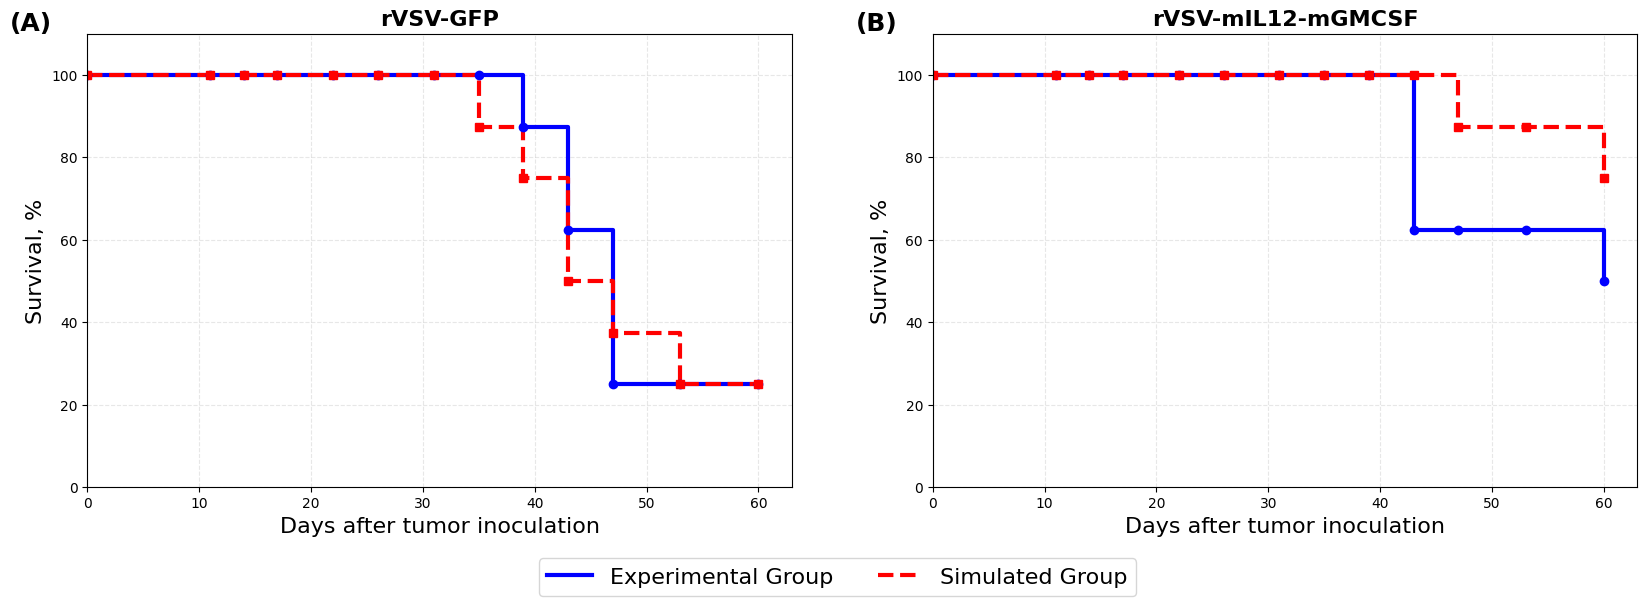

In [15]:
plot_kaplan_meier_survival(
     files=[
          "Tables/Separate_mice_VSV_GFP_with_simulations_corrected.xlsx",
          "Tables/Separate_mice_VSV_mIL12_mGMCSF_with_simulations_corrected.xlsx"
          ],
     lists=[
          ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8"],
          ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8"]
          ],
     x_cols=[
          "time",
          "time"
          ],
     x_values_list=[
          [11,14,17,22,26,31,35,39,43,47,53,60],
          [11,14,17,22,26,31,35,39,43,47,53,60]
          ],
     exp_cols=[
          "Exp",
          "Exp"
          ],
     sim_cols=[
          "Simulation VSV-GFP treatment of mouse from PBS group using d_e_u",
          "Simulation VSV-mIL12-mGMCSF treatment of mouse from PBS group using d_e_u"
          ],
     titles=[
          "rVSV-GFP",
          "rVSV-mIL12-mGMCSF"
          ],
     title_fontsizes=[16, 16],
     y_labels=[
          "Survival, %",
          "Survival, %"
          ],
     y_label_fontsizes=[16,16],
     x_labels=[
          "Days after tumor inoculation",
          "Days after tumor inoculation"
          ],
     x_label_fontsizes=[16,16],
     thresholds=[2000,2000],
     line_designs=[
          'orthogonal',
          'orthogonal'
          ],
     plot_signs=['(A)','(B)'],
     n_cols=2,
     figsize_of_subplot = (10,6),
     legend_type='one',
     legend_fontsize=16
)